<a href="https://colab.research.google.com/github/anujoshi3390/N1H1---Vaccines/blob/main/N1H1_Vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## H1N1 Vaccines

# 1. Project Description & Objective


DESCRIPTION: Beginning in the spring of 2009, the H1N1 influenza virus, commonly referred to as "swine flu," swept across the globe. It is estimated that in the first year, swine flu was responsible for 363,000 deaths worldwide.

OBJECTIVE: The objective of this project is to identify individuals who will not receive a swine flu vaccine. Predicting individuals who will not receive the vaccine will help to inform the CDC’s marketing strategies. To do this, I have analyzed over 26,000 data points collected via phone call through the National 2009 H1N1 Flu Survey. This survey was administered by the National Center for Health Statistics in collaboration with the CDC.

DEFINING KEY TERMS: Throughout this notebook, when the term “unvaccinated” is used, it refers specifically to the annual swine flu vaccinestill recommended today by the CDC.

METHODOLOGY: Logistic Regression

TARGET: h1n1_vaccine - 1 represents no vaccine - 0 represents vaccine

PERFORMANCE METRICS: Performance will be evaluated according to the area under the receiver operating characteristic curve (ROC) along with the accuracy, recall, precision, and f1 scores. A higher value indicates stronger performance.

# 2. Imports and Data

In [72]:
import pandas as pd
import numpy as np
from numpy import ravel
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures,\
Normalizer, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

In [73]:
trainfeatures = pd.read_csv('training_set_features.csv')
trainlabels = pd.read_csv('training_set_labels.csv')

In [74]:
trainfeatures.shape, trainlabels.shape

((26707, 36), (26707, 3))

Merging features and labels dataframes to create one comprehensive dataset.

In [75]:
df = trainfeatures.merge(trainlabels,on='respondent_id',how='outer')

In [76]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [77]:
df.h1n1_vaccine.value_counts()

,count
h1n1_vaccine,
0,21033
1,5674


# 3. Exploratory Data Analysis

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

n our question, we want to uncover who is will not receive a h1n1 vaccine, therefore, we will switch our target variable so that 0 represents receiving the vaccine and 1 represents not receiving the vaccine.

In [79]:
df.h1n1_vaccine = df.h1n1_vaccine.replace(0, "no vaccine")
df.h1n1_vaccine = df.h1n1_vaccine.replace(1, "vaccine")


In [80]:
df.h1n1_vaccine.value_counts()

,count
h1n1_vaccine,
no vaccine,21033
vaccine,5674


In [81]:
df.h1n1_vaccine = df.h1n1_vaccine.replace("no vaccine", 1)
df.h1n1_vaccine = df.h1n1_vaccine.replace("vaccine", 0)

<ipython-input-81-ceb448ab9ae3>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.h1n1_vaccine = df.h1n1_vaccine.replace("vaccine", 0)


In [82]:
df.h1n1_vaccine.value_counts()

,count
h1n1_vaccine,
1,21033
0,5674


In [83]:
df['h1n1_vaccine'].value_counts(normalize=True)

,proportion
h1n1_vaccine,
1,0.787546
0,0.212454


There may be a class imbalance issue given that 78.75% of the dataset did not receive the h1n1 vaccine.

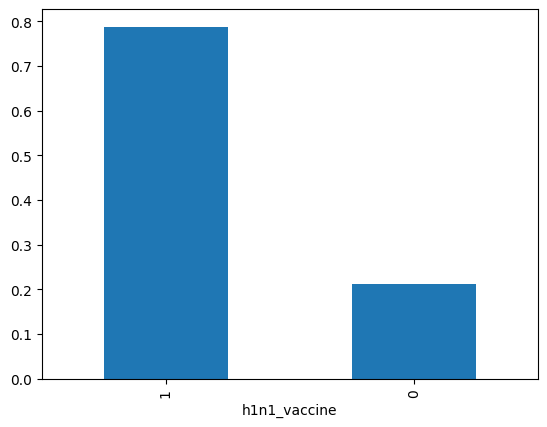

In [84]:
df['h1n1_vaccine'].value_counts(normalize=True).plot(kind='bar');

Let's explore the relationship of other categorical variables with the target variables.

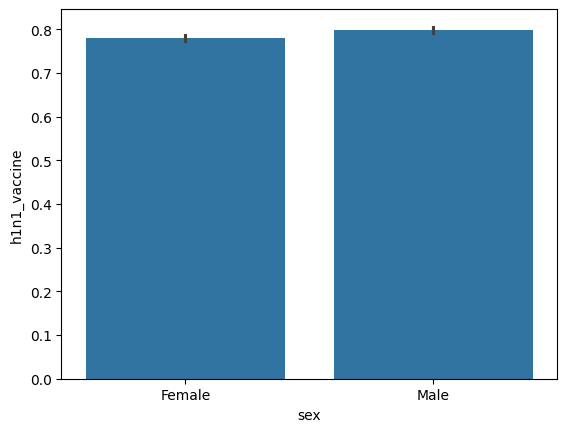

In [85]:
sns.barplot(x=df['sex'], y=df['h1n1_vaccine']);

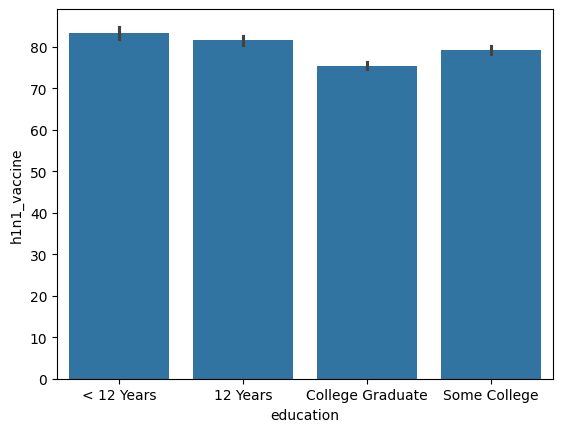

In [86]:
sns.barplot(x=df['education'], y=df['h1n1_vaccine'] * 100);

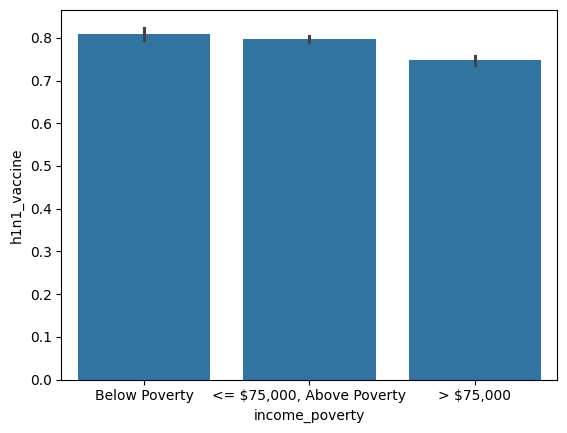

In [87]:
sns.barplot(x=df['income_poverty'], y=df['h1n1_vaccine']);


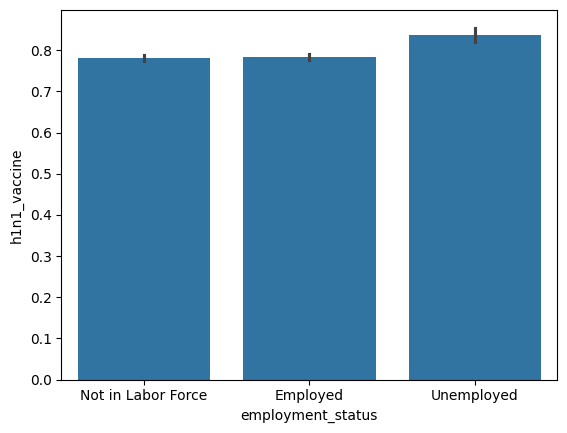

In [88]:
sns.barplot(x=df['employment_status'], y=df['h1n1_vaccine']);


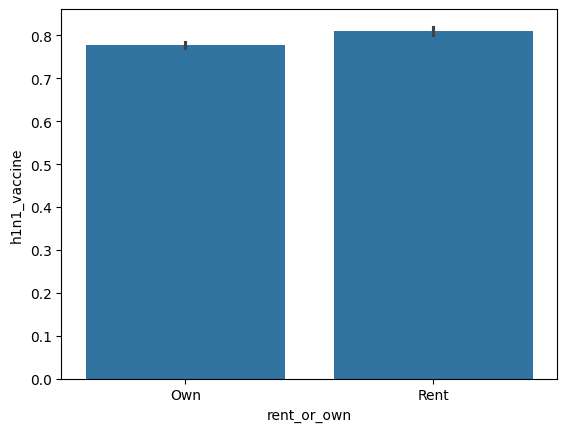

In [89]:
sns.barplot(x=df['rent_or_own'], y=df['h1n1_vaccine']);


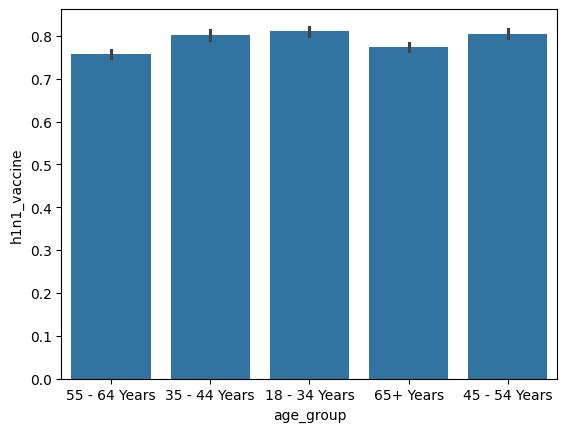

In [90]:
sns.barplot(x=df['age_group'], y=df['h1n1_vaccine']);


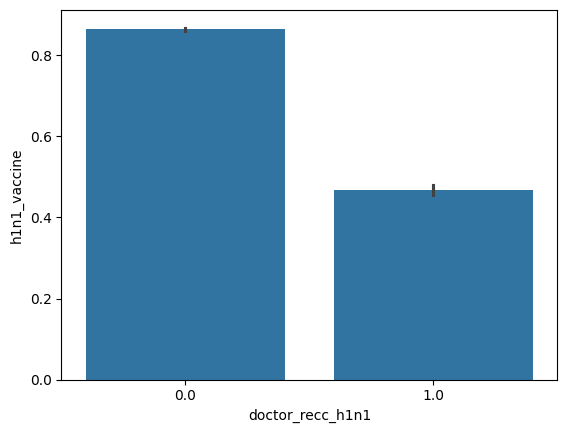

In [91]:
sns.barplot(x=df['doctor_recc_h1n1'], y=df['h1n1_vaccine']);


# 4. Pipeline Creation - H1N1 Vaccine and All Variables

Creating categorical, binary, and simple imputer only column lists to use in pipelines.

In [92]:
df.sex.value_counts()

,count
sex,
Female,15858
Male,10849


In [93]:
df.marital_status.value_counts()

,count
marital_status,
Married,13555
Not Married,11744


In [94]:
df.rent_or_own.value_counts()

,count
rent_or_own,
Own,18736
Rent,5929


In [95]:
categorical_columns = ['age_group','education','race','income_poverty','employment_status', 'hhs_geo_region','census_msa',
                       'household_adults','household_children','employment_industry','employment_occupation']

#binary columns include columns that are binary but need to be one-hot-encoded because they are objects
binary_columns = ['sex','marital_status','rent_or_own']

#simple impute only includes: (1) binary variables that contain 0 and 1 already and (2) survey data that is on a scale from 0-x.
simple_impute_only = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','h1n1_knowledge',
                       'h1n1_concern', 'behavioral_antiviral_meds','behavioral_avoidance', 'behavioral_face_mask',
                      'behavioral_wash_hands','behavioral_large_gatherings','behavioral_outside_home',
                      'behavioral_touch_face','doctor_recc_h1n1','doctor_recc_seasonal','chronic_med_condition',
                      'child_under_6_months','health_worker','health_insurance']

Our X and y exclude respondent ID and both the h1n1 and seasonal vaccine target variables. We are not paying attention to seasonal vaccines in this project.

In [96]:
X = df.iloc[:,1:-2]
y = df['h1n1_vaccine']

Split the data so that we have our training set and testing set.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [63]:
X_train.shape, X_test.shape

((20030, 35), (6677, 35))

Creating subpipes based on the needs of the respective columns.

In [102]:
subpipe_categorical = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

subpipe_binary = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

subpipe_simple_impute_only = Pipeline([
    ('sio_impute', SimpleImputer(strategy='most_frequent'))
])

In [ ]:
Creating first dummy/baseline model to compare our following models to.

In [105]:
CT = ColumnTransformer(transformers=[
    ('categorical', subpipe_categorical, categorical_columns),
    ('binary', subpipe_binary, binary_columns),
    ('simple_impute_only', subpipe_simple_impute_only, simple_impute_only)
], remainder='passthrough')

## 4A. Dummy Model

In [106]:
dummy_pipeline = Pipeline(steps=[
    ('CT',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

In [107]:
dummy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa'...
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [108]:
print('Training set score: ' + str(dummy_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(dummy_pipeline.score(X_test,y_test)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


In [111]:
from sklearn.metrics import RocCurveDisplay



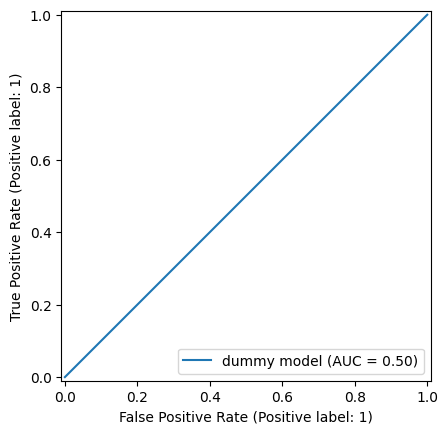

In [123]:
RocCurveDisplay.from_estimator(dummy_pipeline, X_test, y_test, name='dummy model')
plt.show()

Our model must perform better than this!

# 4B. First Simple Model

In [116]:
fsm_pipeline = Pipeline([
    ('CT',CT),
    ('first_simple_model', LogisticRegression())
])

In [117]:
fsm_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa'...
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('first_simple_model', LogisticRegression())])

In [118]:
print('Training set score: ' + str(fsm_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(fsm_pipeline.score(X_test,y_test)))

Training set score: 0.8381427858212681
Test set score: 0.8398981578553243


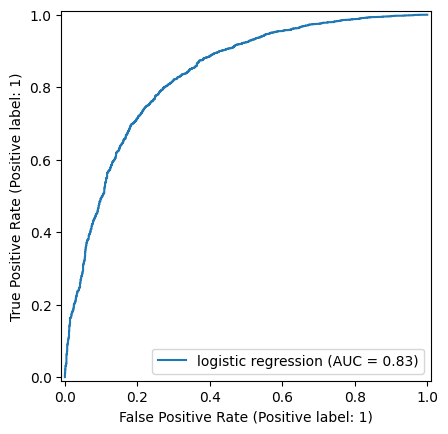

In [125]:
RocCurveDisplay.from_estimator(fsm_pipeline, X_test, y_test, name= 'logistic regression');

This is an improvement from the dummy model. Let's tune it with gridsearching.

# 4C. Tuning First Simple Model with GridSearching


Creating parameters for the grid search. The gridsearch takes 25-40 minutes.

In [127]:
params = {
    'first_simple_model__solver' : ['liblinear','lbfgs'],
    'first_simple_model__max_iter': [10, 100,1000,10_000],
    'first_simple_model__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'first_simple_model__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [128]:
gridsearch = GridSearchCV(
    estimator = fsm_pipeline,
    param_grid=params,
    cv=5,
    verbose=1
)

In [129]:
gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['age_group',
                                                                          'education',
                                                                          'race',
                                                                          'income_poverty',
                                                                          'employment_status',
                                                                          '...
                                                                          'chronic_med_condition',
                                                                          'child_under_6_months',
                                                                          'health_worker',
                                                                          'health_insurance'])])),
                                       ('first_simple_model',
                                        LogisticRegression())]),
             param_grid={'first_simple_model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'first_simple_model__max_iter': [10, 100, 1000, 10000],
                         'first_simple_model__solver': ['liblinear', 'lbfgs'],
                         'first_simple_model__tol': [0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [130]:
best_params = gridsearch.best_params_
best_params

{'first_simple_model__C': 1,
 'first_simple_model__max_iter': 100,
 'first_simple_model__solver': 'lbfgs',
 'first_simple_model__tol': 0.001}

In [131]:
best_pipe = gridsearch.best_estimator_
best_pipe

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa'...
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('first_simple_model', LogisticRegression(C=1, tol=0.001))])

In [132]:
result_df = pd.DataFrame.from_dict(gridsearch.cv_results_, orient='columns')
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_first_simple_model__C,param_first_simple_model__max_iter,param_first_simple_model__solver,param_first_simple_model__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.206421,0.006219,0.030381,0.001061,0.0001,10,liblinear,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,113
1,0.197640,0.005041,0.030332,0.002741,0.0001,10,liblinear,0.0010,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,113
2,0.198461,0.005891,0.028994,0.002006,0.0001,10,liblinear,0.0100,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,113
3,0.200335,0.004030,0.029560,0.000931,0.0001,10,liblinear,0.1000,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,113
4,0.208671,0.010135,0.046258,0.005548,0.0001,10,lbfgs,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.215352,0.001877,0.030256,0.001610,1.0000,10000,liblinear,0.1000,"{'first_simple_model__C': 1, 'first_simple_mod...",0.829006,0.830504,0.830255,0.835996,0.834249,0.832002,0.002656,46
156,0.908336,0.357717,0.054776,0.023328,1.0000,10000,lbfgs,0.0001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831003,0.836745,0.839740,0.835497,0.836495,0.835896,0.002827,10
157,0.374198,0.013992,0.043980,0.000736,1.0000,10000,lbfgs,0.0010,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831003,0.838492,0.838992,0.834498,0.837494,0.836096,0.002986,1
158,0.235958,0.013702,0.044250,0.002215,1.0000,10000,lbfgs,0.0100,"{'first_simple_model__C': 1, 'first_simple_mod...",0.832002,0.832002,0.833500,0.834249,0.835497,0.833450,0.001343,37


In [133]:
print('Training set score: ' + str(best_pipe.score(X_train,y_train)))
print('Test set score: ' + str(best_pipe.score(X_test,y_test)))

Training set score: 0.8375436844732901
Test set score: 0.8400479257151415


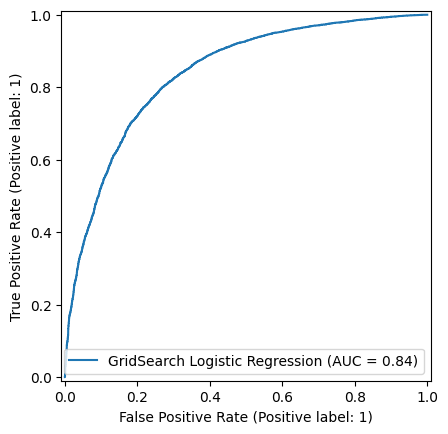

In [135]:
RocCurveDisplay.from_estimator(best_pipe, X_train, y_train, name='GridSearch Logistic Regression');


In [136]:
cv = cross_validate(best_pipe, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

{'fit_time': array([0.37135553, 0.32809663, 0.32680893, 1.00387406, 0.50437546]),
 'score_time': array([0.05954099, 0.04443455, 0.06137705, 0.09128141, 0.04640412]),
 'test_r2': array([-0.0101147 ,  0.03464666,  0.03763075,  0.01162173,  0.02951093]),
 'train_r2': array([0.03953481, 0.03543345, 0.02312935, 0.02814093, 0.02664921]),
 'test_neg_mean_squared_error': array([-0.16899651, -0.16150774, -0.16100849, -0.16550175, -0.16250624]),
 'train_neg_mean_squared_error': array([-0.16075886, -0.16144533, -0.16350474, -0.16263105, -0.16288068])}

In [137]:
y_preds4c = best_pipe.predict(X_test)

In [141]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

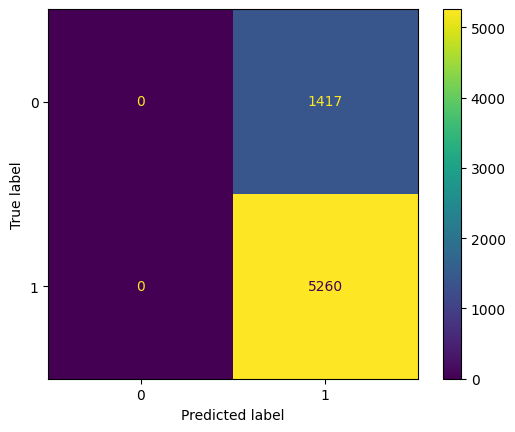

In [143]:
ConfusionMatrixDisplay.from_estimator(dummy_pipeline, X_test, y_test)
plt.show()

In [145]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


In [146]:
print(f"Our 4C model's accuracy on the test set is {round(accuracy_score(y_test, y_preds4c) * 100, 2)}%.")
print(f"Our 4C model's recall on the test set is {round(recall_score(y_test, y_preds4c) * 100, 2)}%.")
print(f"Our 4C model's precision on the test set is {round(precision_score(y_test, y_preds4c) * 100, 2)}%.")
print(f"Our 4C model's F1-score on the test set is {round(f1_score(y_test, y_preds4c) * 100, 2)}%.")

Our 4C model's accuracy on the test set is 84.0%.
Our 4C model's recall on the test set is 95.08%.
Our 4C model's precision on the test set is 86.08%.
Our 4C model's F1-score on the test set is 90.35%.


Tuning our model based on the gridsearch improved our model!

# 4D. Logistic Regression with SMOTE

Earlier we mentioned a possible class imbalance (section 3). Let's see if adding SMOTE to the model improves the performance.

In [147]:
smote_pipeline = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('best_pipe', LogisticRegression(C=1,max_iter=100, solver='lbfgs',tol=.0001))
])

In [148]:
smote_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa'...
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('sm', SMOTE(random_state=42)),
                ('best_pipe', LogisticRegression(C=1))])

In [149]:
print('Training set score: ' + str(smote_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(smote_pipeline.score(X_test,y_test)))


Training set score: 0.7842735896155766
Test set score: 0.7841845140032949


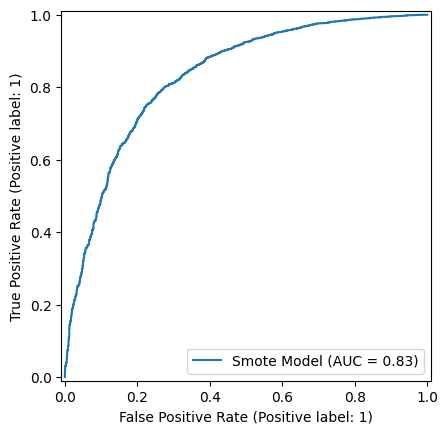

In [151]:
RocCurveDisplay.from_estimator(smote_pipeline, X_test, y_test, name='Smote Model');


In [152]:
cv = cross_validate(smote_pipeline, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'fit_time': array([1.03070617, 1.00469184, 1.88421321, 0.96439147, 0.99796271]),
 'score_time': array([0.03846812, 0.03886747, 0.03668785, 0.04054999, 0.0443697 ]),
 'test_r2': array([-0.38014194, -0.29061922, -0.33538058, -0.2373363 , -0.30143926]),
 'train_r2': array([-0.26135626, -0.28149024, -0.27403321, -0.30078451, -0.28474846]),
 'test_neg_mean_squared_error': array([-0.23090364, -0.21592611, -0.22341488, -0.20718922, -0.21792312]),
 'train_neg_mean_squared_error': array([-0.21112082, -0.21449076, -0.21324264, -0.21767349, -0.21499001])}

In [153]:
y_preds4d = smote_pipeline.predict(X_test)

In [154]:
print(f"""
Our 4d model's accuracy on the test set is {round(accuracy_score(y_test, y_preds4d), 4) * 100}%. \n
Our 4d model's recall on the test set is {round(recall_score(y_test, y_preds4d), 5) * 100}%. \n
Our 4d model's precision on the test set is {round(precision_score(y_test, y_preds4d), 4) * 100}%. \n
Our 4d model's f1-score on the test is {round(f1_score(y_test, y_preds4d), 3) * 100}%.
""")



Our 4d model's accuracy on the test set is 78.42%. 

Our 4d model's recall on the test set is 80.038%. 

Our 4d model's precision on the test set is 91.5%. 

Our 4d model's f1-score on the test is 85.39999999999999%.



Adding SMOTE to the model decreased it's performance so if we are going to move forward with including all the columns in our model, we will move forward with the gridsearch logistic regression without SMOTE.

# 5. Pipeline Creation - H1N1 Vaccine and Select Columns

Before choosing our model, let's explore what happens to our model if we decrease the number of columns/variables.



In [155]:
X_select = df[['age_group', 'education', 'race', 'income_poverty', 'employment_status', 'marital_status', 'sex','hhs_geo_region']]
y_select = df['h1n1_vaccine']

In [156]:
categorical_columns = ['age_group', 'education', 'race', 'income_poverty', 'employment_status', 'hhs_geo_region']
binary_columns = ['sex', 'marital_status']


In [157]:
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_select, y_select, random_state=42)

In [159]:
subpipe_categorical = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

subpipe_binary = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [160]:
CT = ColumnTransformer(transformers=[
    ('categorical', subpipe_categorical, categorical_columns),
    ('binary', subpipe_binary, binary_columns)
], remainder='passthrough')

# 5A. Dummy Model

Creating our dummy model for our new pipelines that include only select columns.



In [161]:
dummy_pipeline = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [163]:
dummy_pipeline.fit(X_train_select,y_train_select)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region']),
                                                 ('binary',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'marital_status'])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [164]:
print('Training set score: ' + str(dummy_pipeline.score(X_train_select,y_train_select)))
print('Test set score: ' + str(dummy_pipeline.score(X_test_select,y_test_select)))


Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


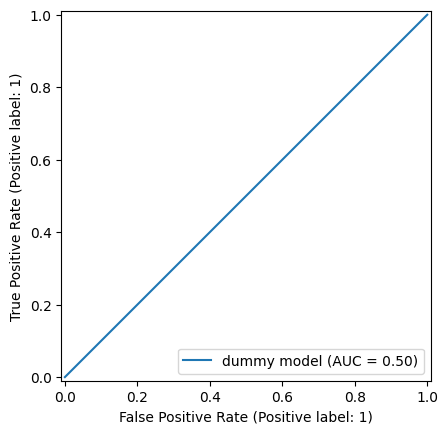

In [166]:
RocCurveDisplay.from_estimator(dummy_pipeline, X_test_select, y_test_select, name='dummy model');


# 5B. First Simple Model for Select Columns

In [167]:
fsm_pipeline = Pipeline([
    ('CT', CT),
    ('first_simple_model', LogisticRegression())
])

In [168]:
fsm_pipeline.fit(X_train_select,y_train_select)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region']),
                                                 ('binary',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'marital_status'])])),
                ('first_simple_model', LogisticRegression())])

In [169]:
print('Training set score: ' + str(fsm_pipeline.score(X_train_select,y_train_select)))
print('Test set score: ' + str(fsm_pipeline.score(X_test_select,y_test_select)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


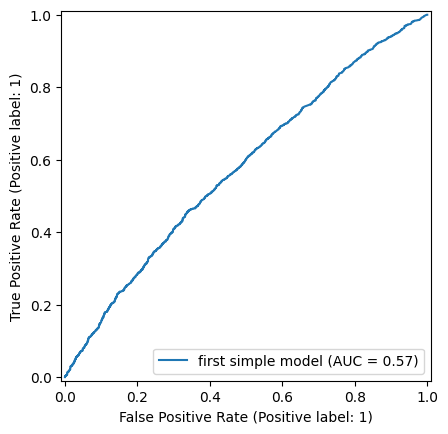

In [171]:
RocCurveDisplay.from_estimator(fsm_pipeline, X_test_select, y_test_select, name='first simple model');


This does not look good. Let's gridsearch to see if it improves our model at all.

## 5C. Tuning First Simple Model with GridSearching

In [173]:
params = {
    'first_simple_model__solver' : ['liblinear','lbfgs'],
    'first_simple_model__max_iter': [10, 100,1000,10_000],
    'first_simple_model__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'first_simple_model__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [174]:
gridsearch_select = GridSearchCV(
    estimator = fsm_pipeline,
    param_grid = params,
    cv=5,
    verbose=1)

In [175]:
gridsearch_select.fit(X_train_select,y_train_select)


Fitting 5 folds for each of 160 candidates, totalling 800 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['age_group',
                                                                          'education',
                                                                          'race',
                                                                          'income_poverty',
                                                                          'employment_status',
                                                                          '...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['sex',
                                                                          'marital_status'])])),
                                       ('first_simple_model',
                                        LogisticRegression())]),
             param_grid={'first_simple_model__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'first_simple_model__max_iter': [10, 100, 1000, 10000],
                         'first_simple_model__solver': ['liblinear', 'lbfgs'],
                         'first_simple_model__tol': [0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [176]:
best_params_select = gridsearch_select.best_params_
best_params_select

{'first_simple_model__C': 0.0001,
 'first_simple_model__max_iter': 10,
 'first_simple_model__solver': 'liblinear',
 'first_simple_model__tol': 0.0001}

In [177]:
best_pipe_select = gridsearch_select.best_estimator_
best_pipe_select

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region']),
                                                 ('binary',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'marital_status'])])),
                ('first_simple_model',
                 LogisticRegression(C=0.0001, max_iter=10,
                                    solver='liblinear'))])

In [179]:
result_df = pd.DataFrame.from_dict(gridsearch_select.cv_results_,orient='columns')


In [180]:
print('Training set score: ' + str(best_pipe_select.score(X_train_select,y_train)))
print('Test set score: ' + str(best_pipe_select.score(X_test_select,y_test)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


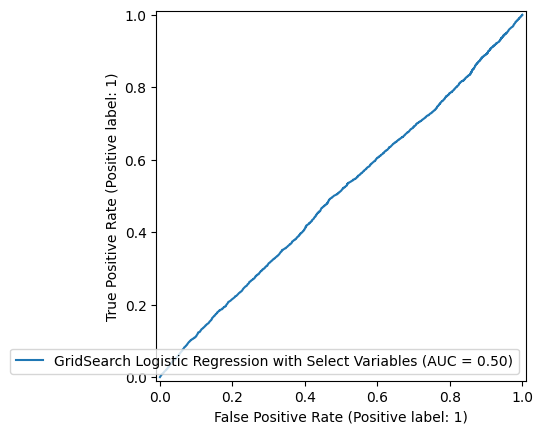

In [182]:
RocCurveDisplay.from_estimator(best_pipe_select, X_train_select, y_train_select, name = 'GridSearch Logistic Regression with Select Variables');


Overall, this is not a good performance. Let's go back to using all columns in our model.

# 6. FINAL STAGE - Exploring Prediction

Refer to section 4C of selecting the best model including all the variables.

In [183]:
final_model = best_pipe
final_model

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa'...
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_h1n1',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'child_under_6_months',
                                                   'health_worker',
                                                   'health_insurance'])])),
                ('first_simple_model', LogisticRegression(C=1, tol=0.001))])

# 6A. Final Model Evaluation

Let's evaluate our model once more just to be extra careful.

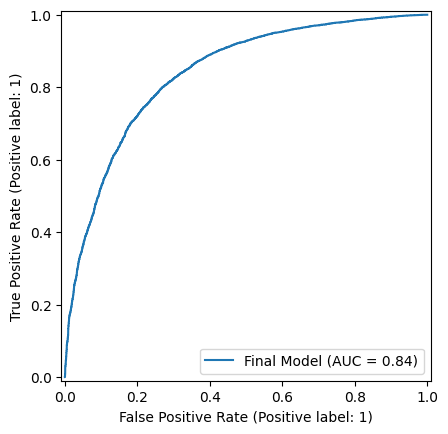

In [185]:
RocCurveDisplay.from_estimator(best_pipe, X_train, y_train, name='Final Model');

In [186]:
print('Training set score: ' + str(final_model.score(X_train,y_train)))
print('Test set score: ' + str(final_model.score(X_test,y_test)))

Training set score: 0.8375436844732901
Test set score: 0.8400479257151415


In [188]:
from sklearn.model_selection import cross_validate

# final_model should be a pipeline or an estimator that is already defined
cv = cross_validate(
    final_model,
    X_train,
    y_train,
    scoring=['r2', 'neg_mean_squared_error'],
    return_train_score=True
)

# To view the results nicely
import pandas as pd
pd.DataFrame(cv)

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,1.341740,0.132693,-0.010115,0.039535,-0.168997,-0.160759
1,1.019192,0.067173,0.034647,0.035433,-0.161508,-0.161445
2,0.297094,0.037639,0.037631,0.023129,-0.161008,-0.163505
3,0.337665,0.035814,0.011622,0.028141,-0.165502,-0.162631
4,0.313401,0.040579,0.029511,0.026649,-0.162506,-0.162881


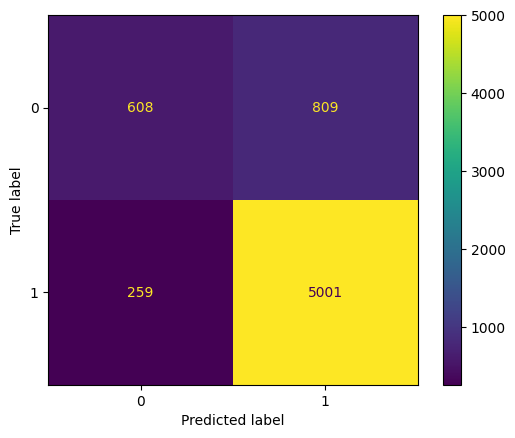

In [192]:
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test);

In [193]:
final_preds = final_model.predict(X_test)

## 6B. Final Model Interpretation

In [195]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Compute metrics
acc = round(accuracy_score(y_test, final_preds) * 100, 2)
rec = round(recall_score(y_test, final_preds) * 100, 2)
prec = round(precision_score(y_test, final_preds) * 100, 2)
f1 = round(f1_score(y_test, final_preds) * 100, 2)

# Try ROC AUC safely
try:
    auc = round(roc_auc_score(y_test, final_preds) * 100, 2)
except Exception as e:
    auc = "N/A"
    print("⚠️ ROC AUC could not be calculated:", e)

# Print results
print(f"""
The final model's accuracy on the test set is {acc}%.
The final model's recall on the test set is {rec}%.
The final model's precision on the test set is {prec}%.
The final model's F1-score on the test is {f1}%.
The final model's ROC AUC score on the test is {auc}%.
""")


The final model's accuracy on the test set is 84.0%.
The final model's recall on the test set is 95.08%.
The final model's precision on the test set is 86.08%.
The final model's F1-score on the test is 90.35%.
The final model's ROC AUC score on the test is 68.99%.



In [196]:
# Only if your model supports predict_proba
probs = final_model.predict_proba(X_test)[:, 1]
roc_auc = round(roc_auc_score(y_test, probs) * 100, 2)

INTERPRETATION: While the final model’s overall accuracy score was 84%, the recall rate was 95%. This tells us that of individuals who will not receive the vaccine, the model will accurately predict 95% of them. This is good news for us because, for this business question, we are mostly concerned with identifying unvaccinated individuals. It won’t hurt to market to an individual who will indeed get the vaccine. We would rather err on the side of identifying a larger volume of unvaccinated individuals. Let’s take a sneak peak at what this machine learning model tells us.



# 6C. Creating Predictions DataFrame

Let's create a new dataframe that includes our predictions to evaluate what the predictions tell us about people less likely to receive the vaccine.

In [197]:
X_preds = X_test.copy()

In [198]:
X_preds['Predictions'] = final_preds
X_preds['True Values'] = y_test

In [199]:
X_preds

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,Predictions,True Values
15772,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,atmpeygn,"MSA, Principle City",NaN,NaN,NaN,NaN,1,1
9407,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,fpwskwrf,"MSA, Principle City",1.0,1.0,NaN,NaN,1,1
16515,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Own,Employed,atmpeygn,"MSA, Not Principle City",0.0,1.0,mfikgejo,mxkfnird,1,1
23353,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Own,Employed,bhuqouqj,Non-MSA,1.0,2.0,cfqqtusy,xtkaffoo,1,1
10008,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,wxleyezf,xtkaffoo,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25990,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,oxchjgsf,Non-MSA,1.0,0.0,ldnlellj,hodpvpew,1,1
14302,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,mcubkhph,ukymxvdu,1,1
3817,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Own,Employed,bhuqouqj,"MSA, Principle City",1.0,0.0,wlfvacwt,xtkaffoo,1,0
13912,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,bhuqouqj,"MSA, Not Principle City",1.0,1.0,mfikgejo,mxkfnird,1,1


# 6D. Exploring Data Based on Target Predictions #

Creating a function to explore the relationship between our dependent variable of h1n1 vaccine predictions and various independent variables in our dataset.

In [231]:
def explore(x):
    fig, ax = plt.subplots(figsize=(24,12))
    sns.barplot(x=x, y='Predictions', palette='colorblind', data=X_preds);

    x_groupby = (X_preds.groupby([x]).mean().sort_values(by='Predictions', ascending=False))
    x_groupby = x_groupby[['Predictions']]
    print(x_groupby)

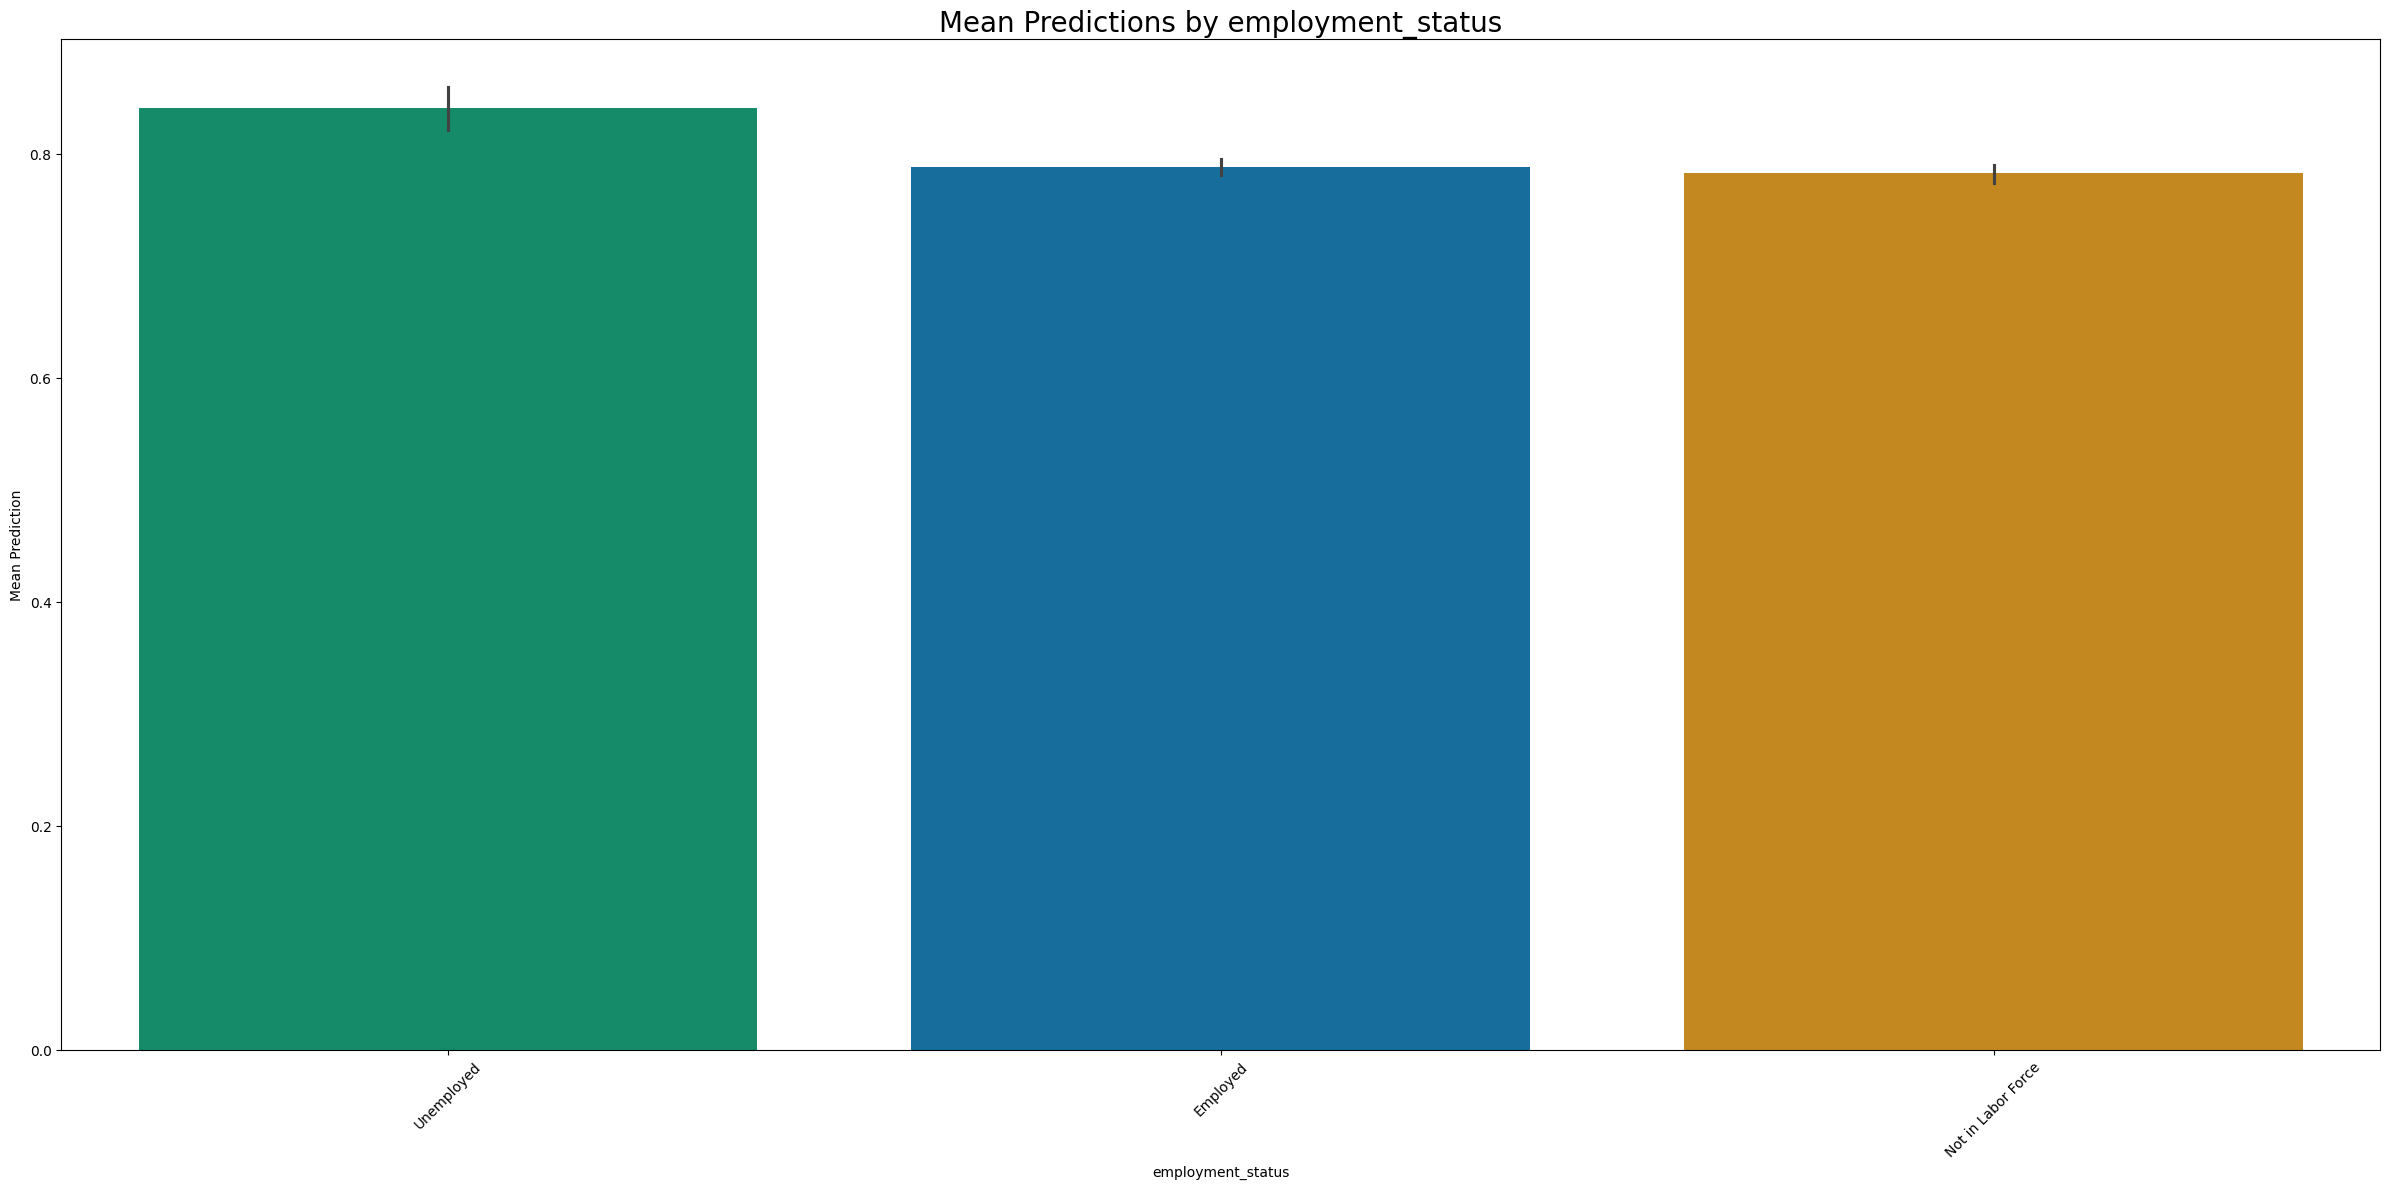

                    Mean Prediction
employment_status                  
Unemployed                 0.841111
Employed                   0.788224
Not in Labor Force         0.782446


In [230]:
X_preds = X_test.copy()
X_preds['Predictions'] = final_model.predict_proba(X_test)[:, 1]  # or .predict()
X_preds.head()
explore('employment_status')

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def explore(x):
    if x not in X_preds.columns:
        print(f" Column '{x}' not found in X_preds.")
        return

    if 'Predictions' not in X_preds.columns:
        print(" 'Predictions' column not found. Make sure you've added it.")
        return

    # Ensure 'Predictions' is numeric
    X_preds['Predictions'] = pd.to_numeric(X_preds['Predictions'], errors='coerce')

    # Plot
    plt.figure(figsize=(24, 12))
    order = X_preds.groupby(x)['Predictions'].mean().sort_values(ascending=False).index

    sns.barplot(x=x, y='Predictions', data=X_preds, order=order, palette='colorblind')
    plt.xticks(rotation=45)
    plt.title(f"Mean Predictions by {x}", fontsize=20)
    plt.xlabel(x)
    plt.ylabel("Mean Prediction")
    plt.tight_layout()
    plt.show()

    # Print groupby means only on 'Predictions'
    x_groupby = X_preds.groupby(x)['Predictions'].mean().sort_values(ascending=False)
    print(x_groupby.to_frame(name='Mean Prediction'))

    # Add prediction values to your test set
X_preds = X_test.copy()
X_preds['Predictions'] = final_model.predict_proba(X_test)[:, 1]  # For classifiers with prob output
# OR
# X_preds['Predictions'] = final_model.predict(X_test)  # For predicted class labels

In [232]:
def explore(x):
    if x not in X_preds.columns:
        print(f" Column '{x}' not found in X_preds.")
        return

    if 'Predictions' not in X_preds.columns:
        print(" 'Predictions' column not found. Make sure you've added it.")
        return

    # Ensure 'Predictions' is numeric
    X_preds['Predictions'] = pd.to_numeric(X_preds['Predictions'], errors='coerce')

    # Group by and sort
    order = X_preds.groupby(x)['Predictions'].mean().sort_values(ascending=False).index

    # Plot
    plt.figure(figsize=(24, 12))
    sns.barplot(data=X_preds, x=x, y='Predictions', hue=x, order=order, dodge=False, palette='colorblind', legend=False)
    plt.xticks(rotation=45)
    plt.title(f"Mean Predictions by {x}", fontsize=20)
    plt.xlabel(x)
    plt.ylabel("Mean Prediction")
    plt.tight_layout()
    plt.show()

    # Print groupby means
    x_groupby = X_preds.groupby(x)['Predictions'].mean().sort_values(ascending=False)
    print(x_groupby.to_frame(name='Mean Prediction'))

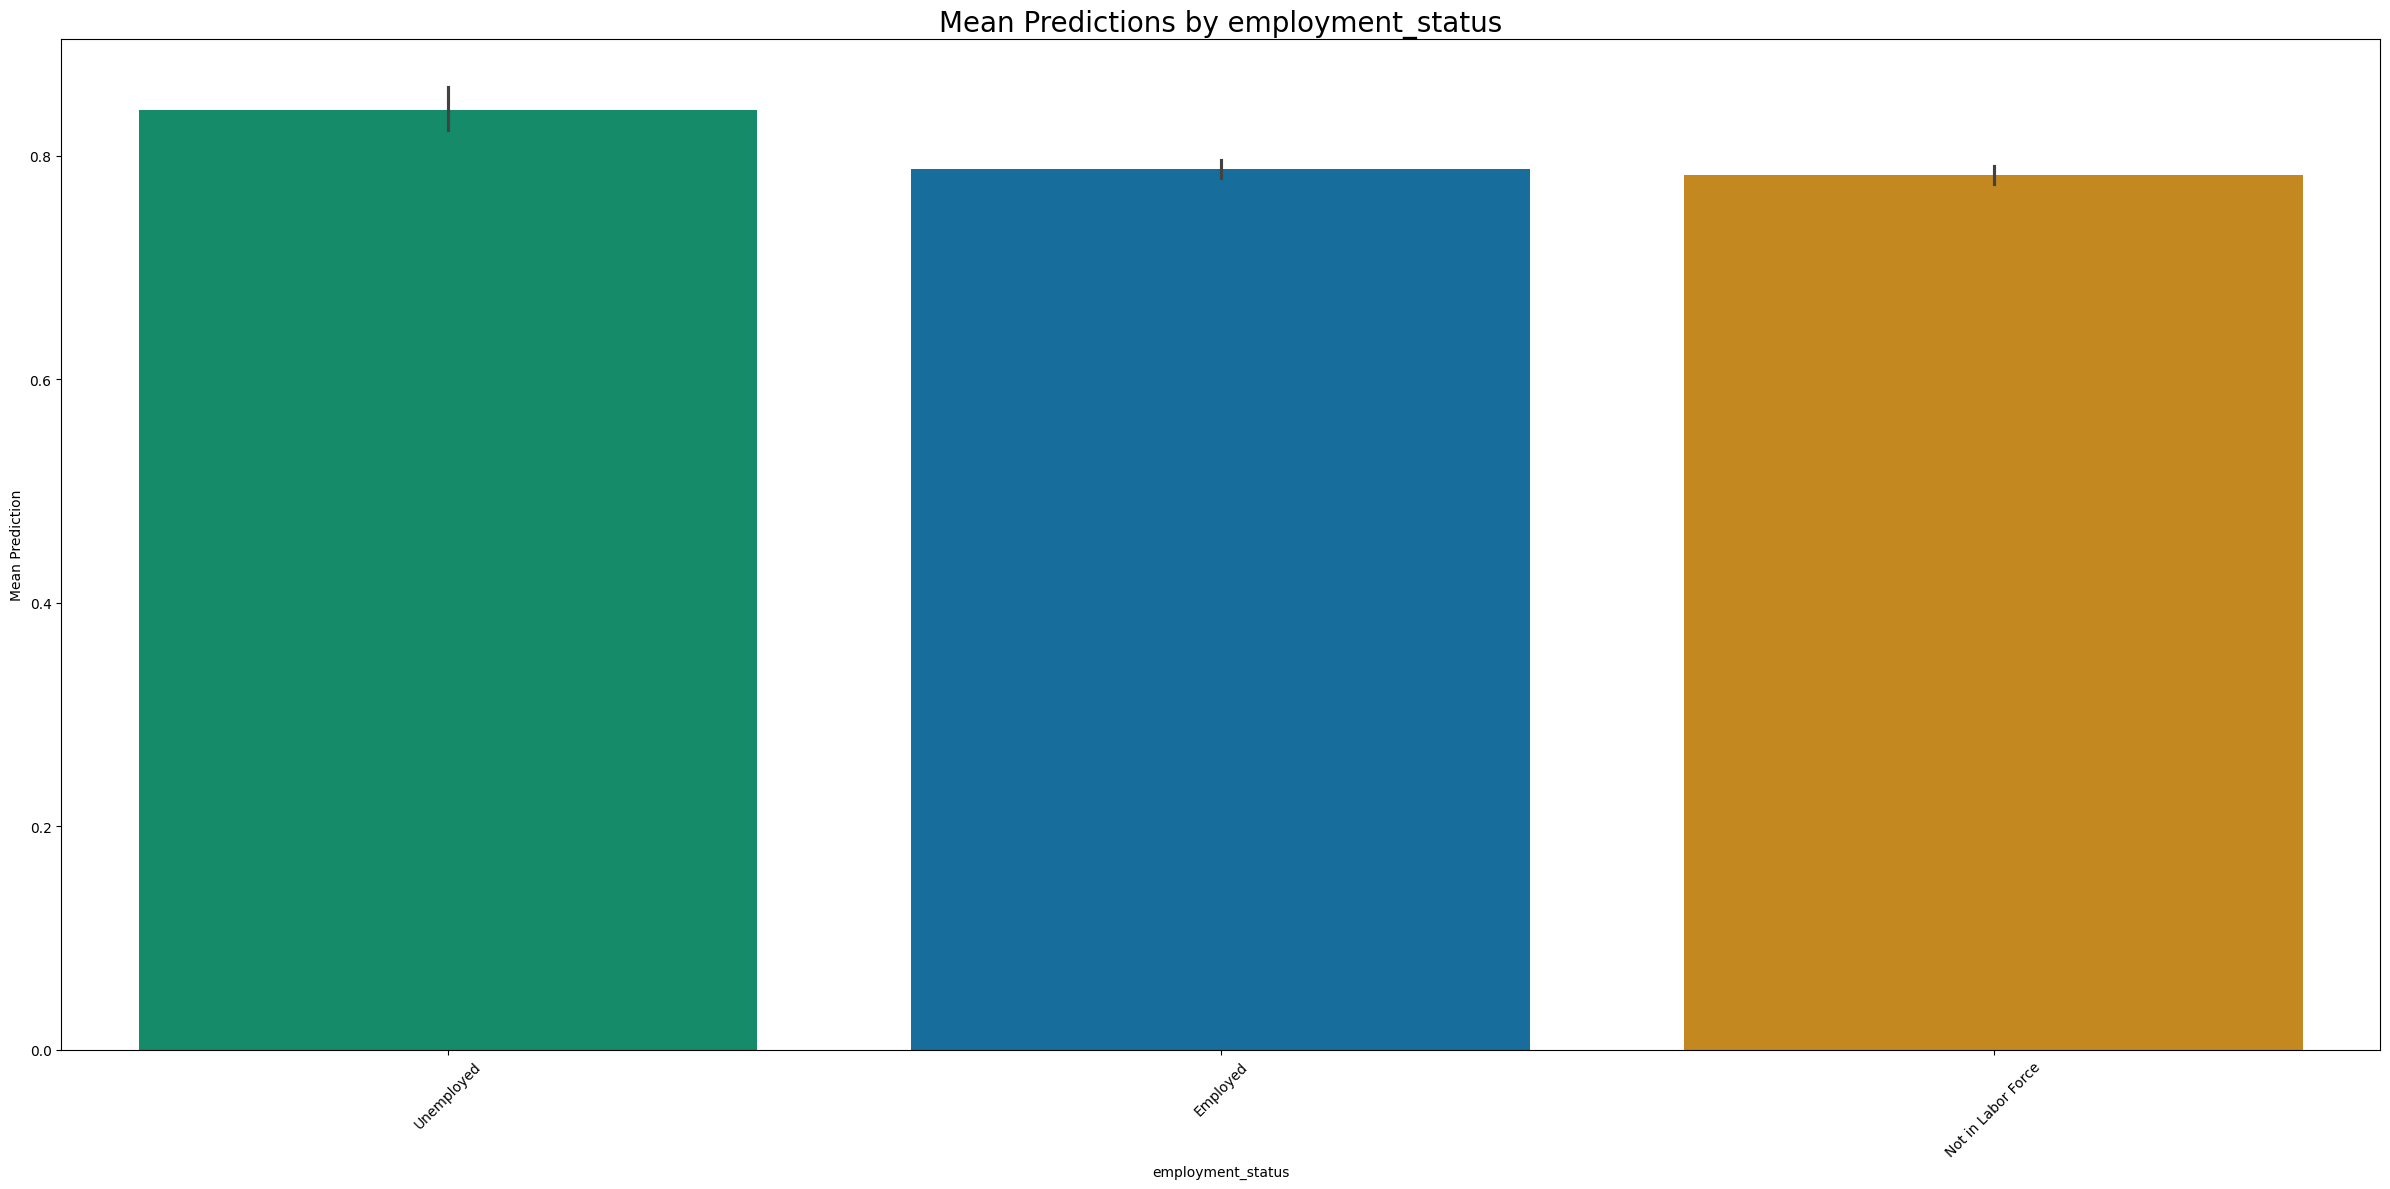

                    Mean Prediction
employment_status                  
Unemployed                 0.841111
Employed                   0.788224
Not in Labor Force         0.782446


In [233]:
explore('employment_status')

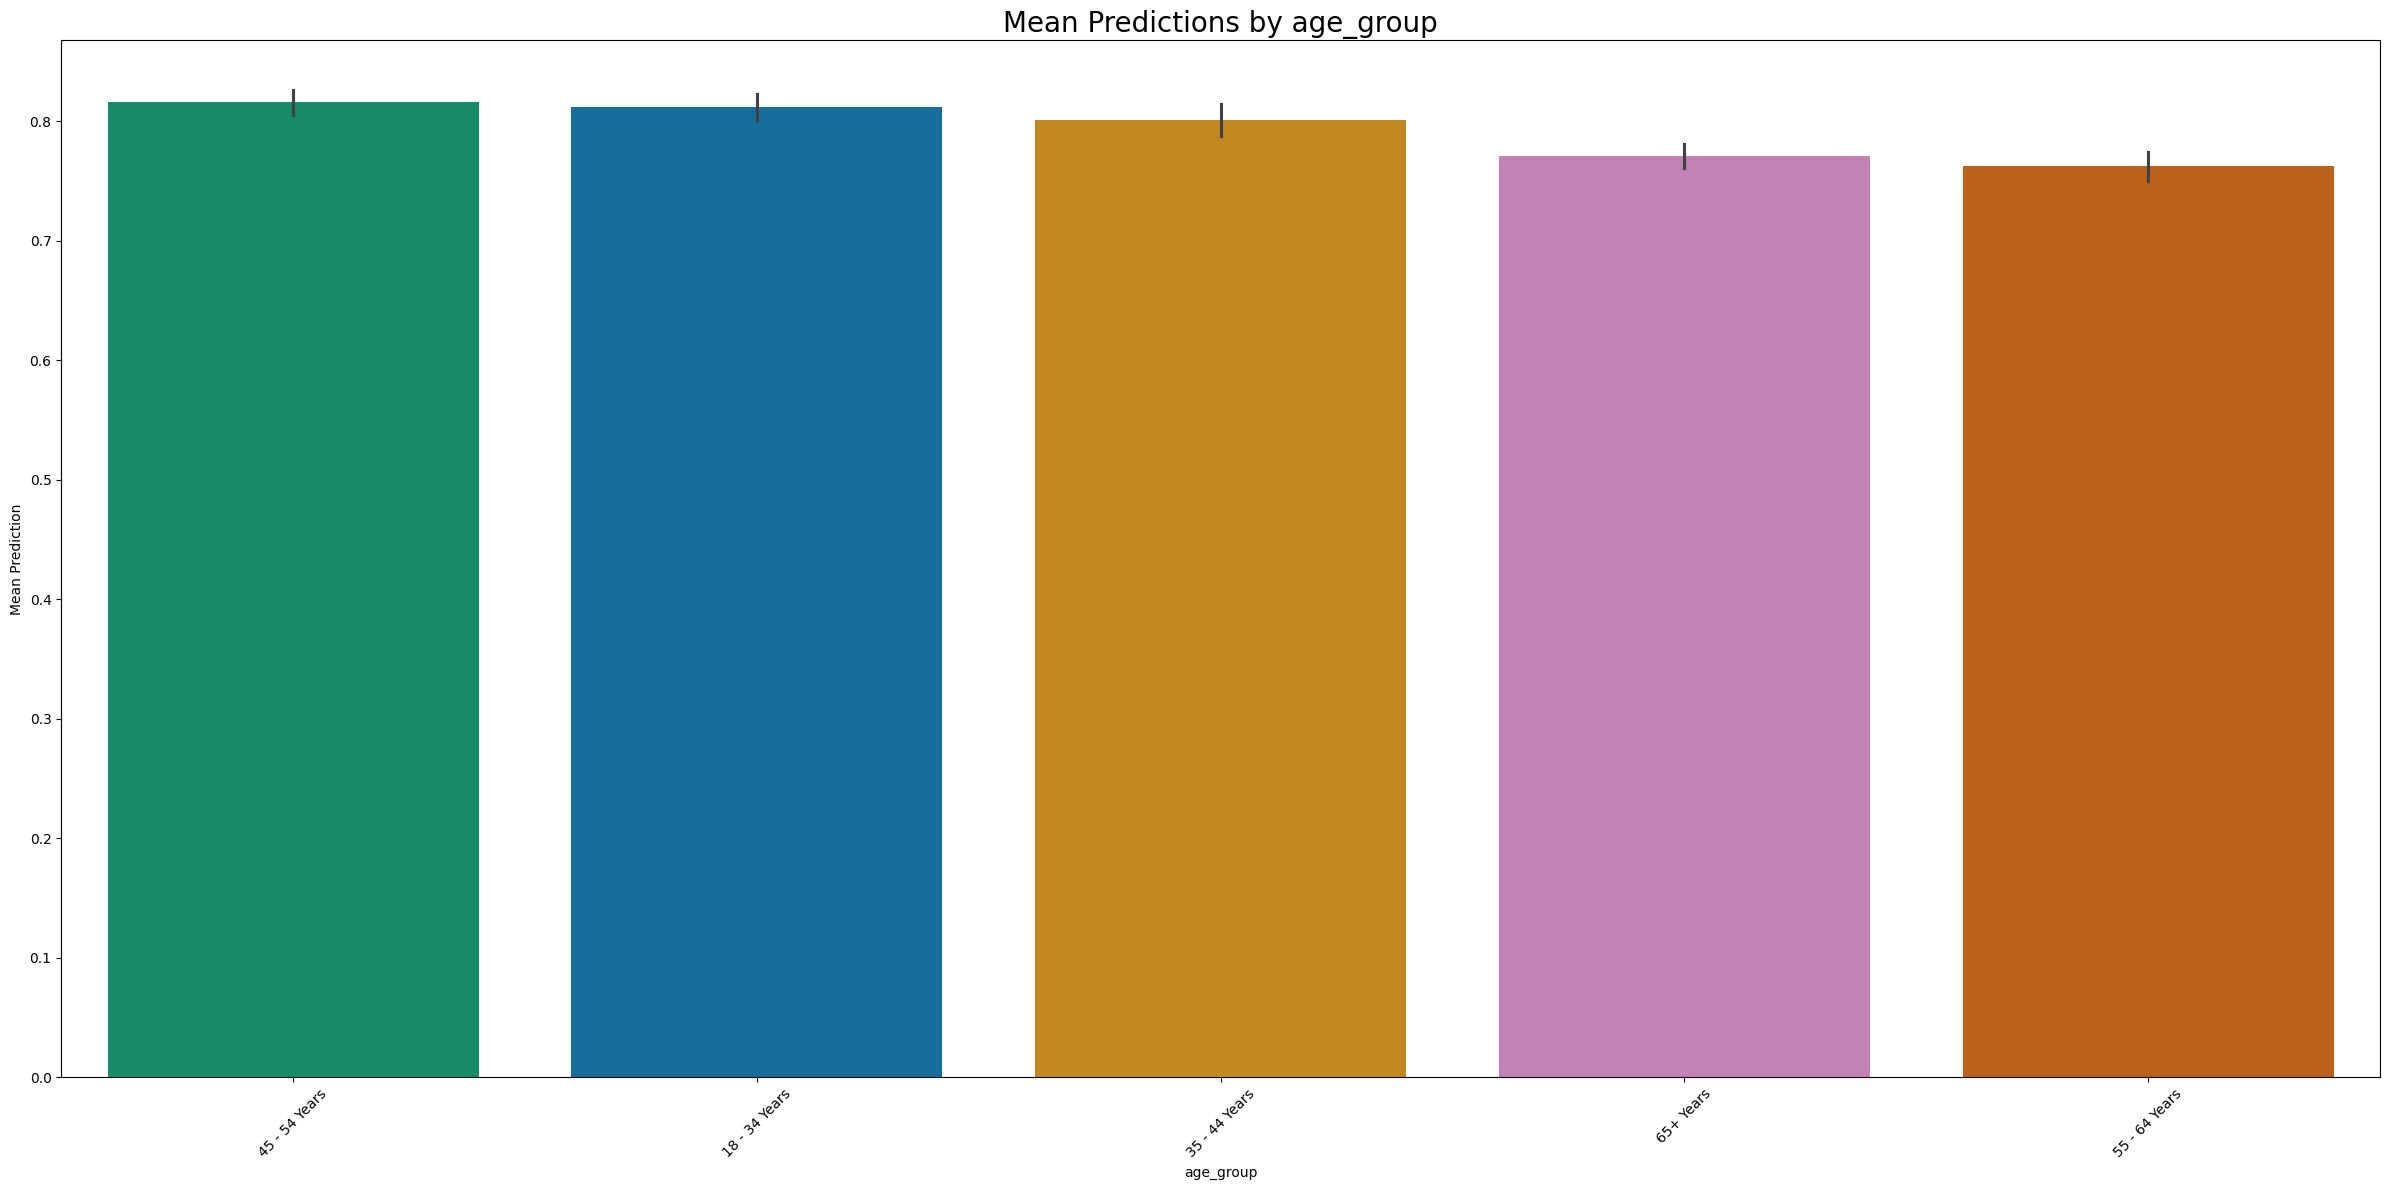

               Mean Prediction
age_group                     
45 - 54 Years         0.815909
18 - 34 Years         0.811964
35 - 44 Years         0.800575
65+ Years             0.771142
55 - 64 Years         0.762874


In [234]:
explore('age_group')

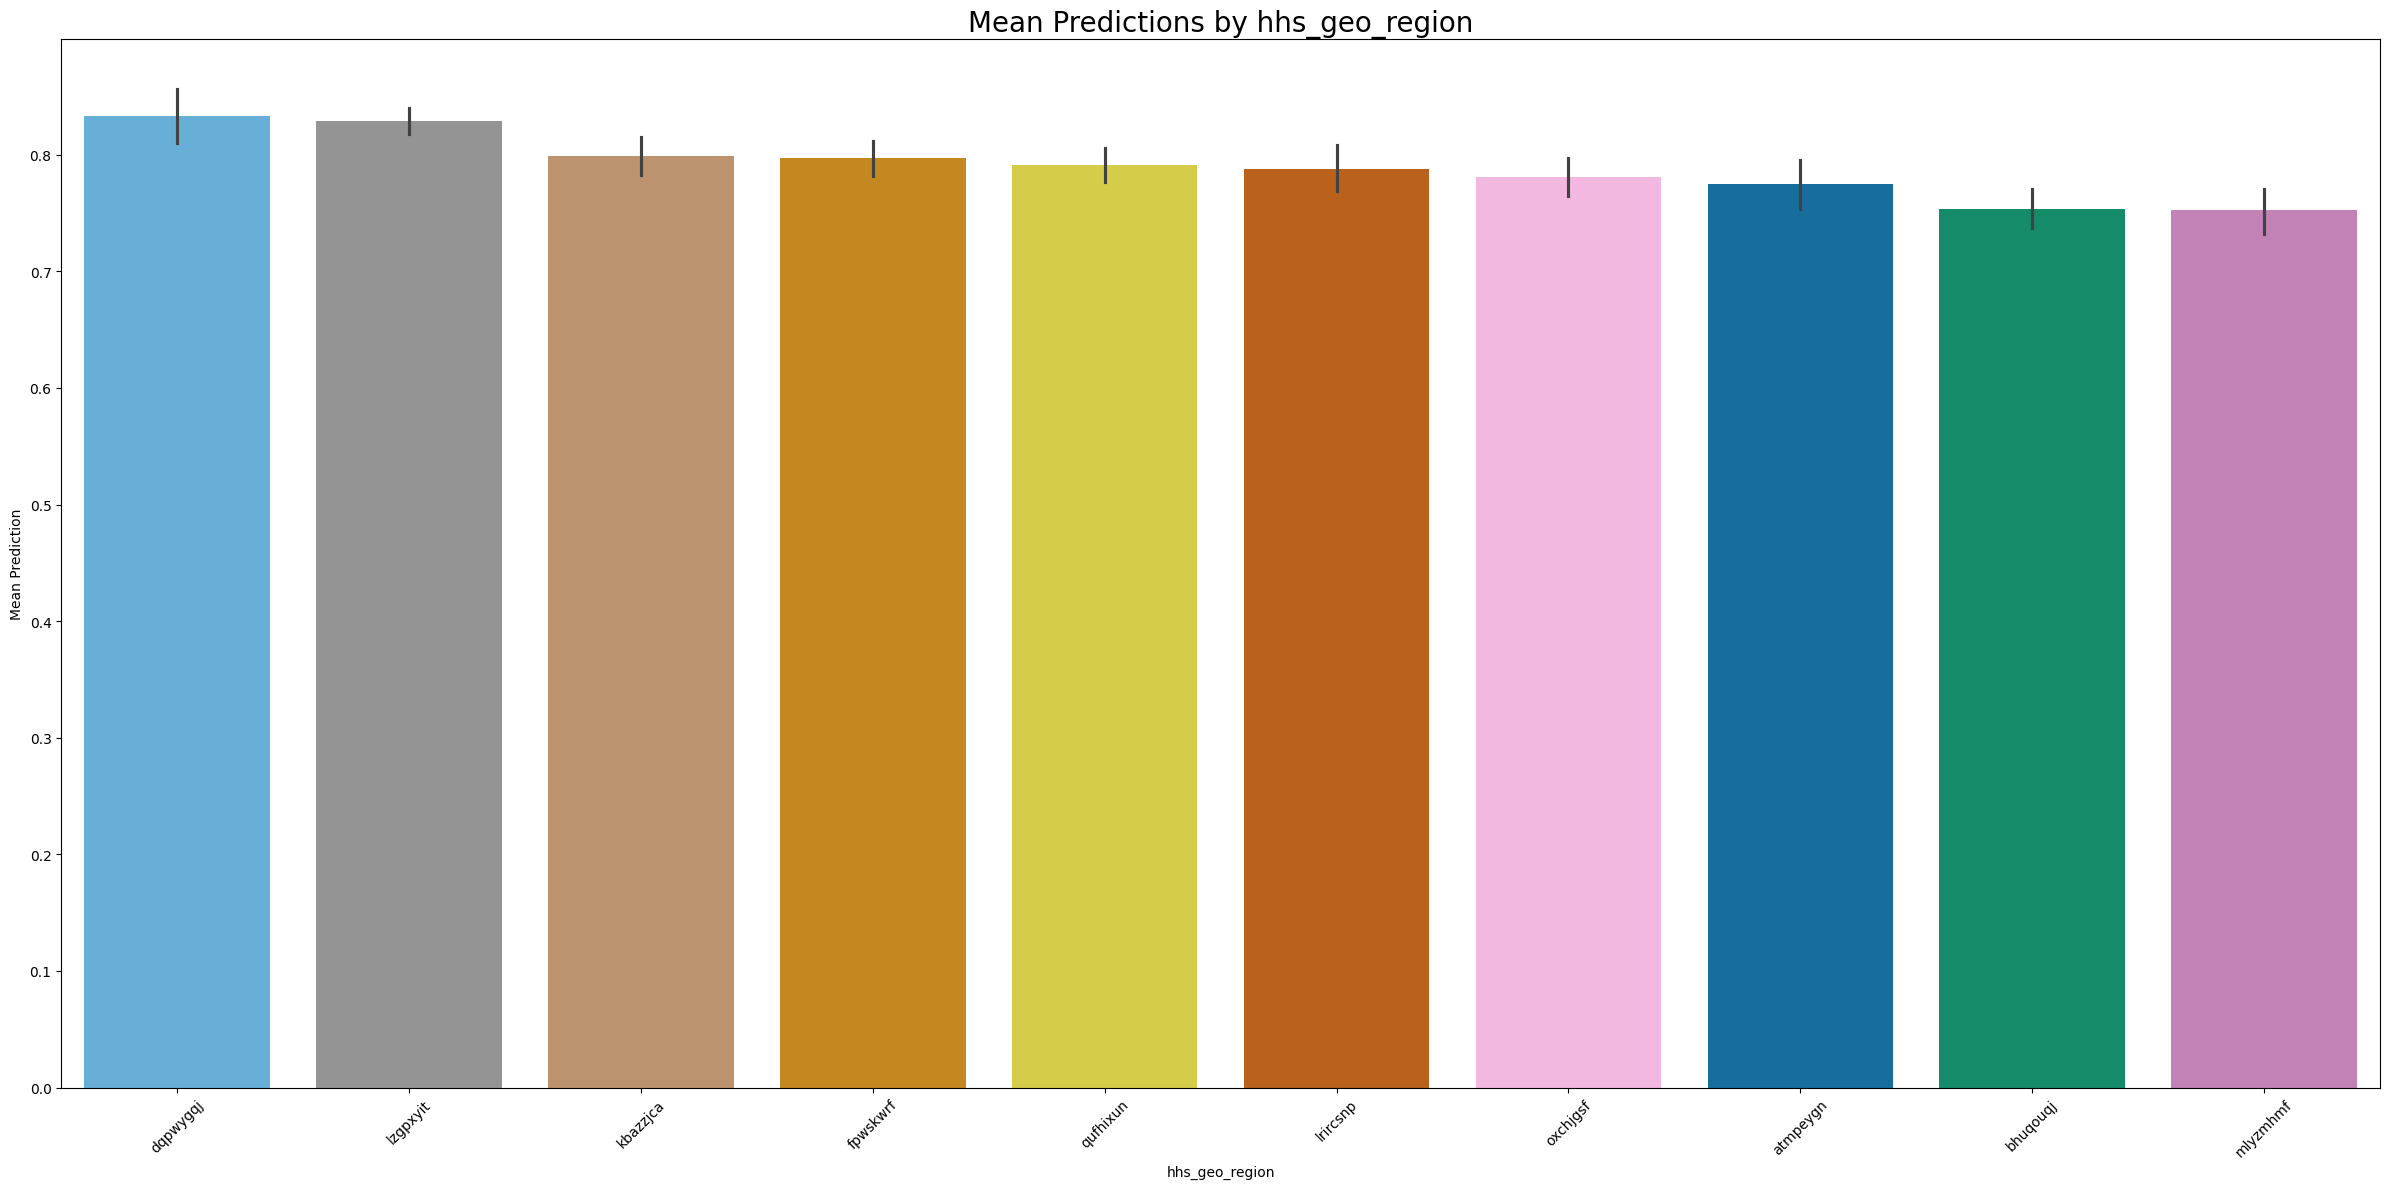

                Mean Prediction
hhs_geo_region                 
dqpwygqj               0.833021
lzgpxyit               0.828895
kbazzjca               0.798858
fpwskwrf               0.796827
qufhixun               0.791364
lrircsnp               0.788068
oxchjgsf               0.781051
atmpeygn               0.774758
bhuqouqj               0.753567
mlyzmhmf               0.752294


In [235]:
explore('hhs_geo_region')
#coded in random strings for privacy purposes


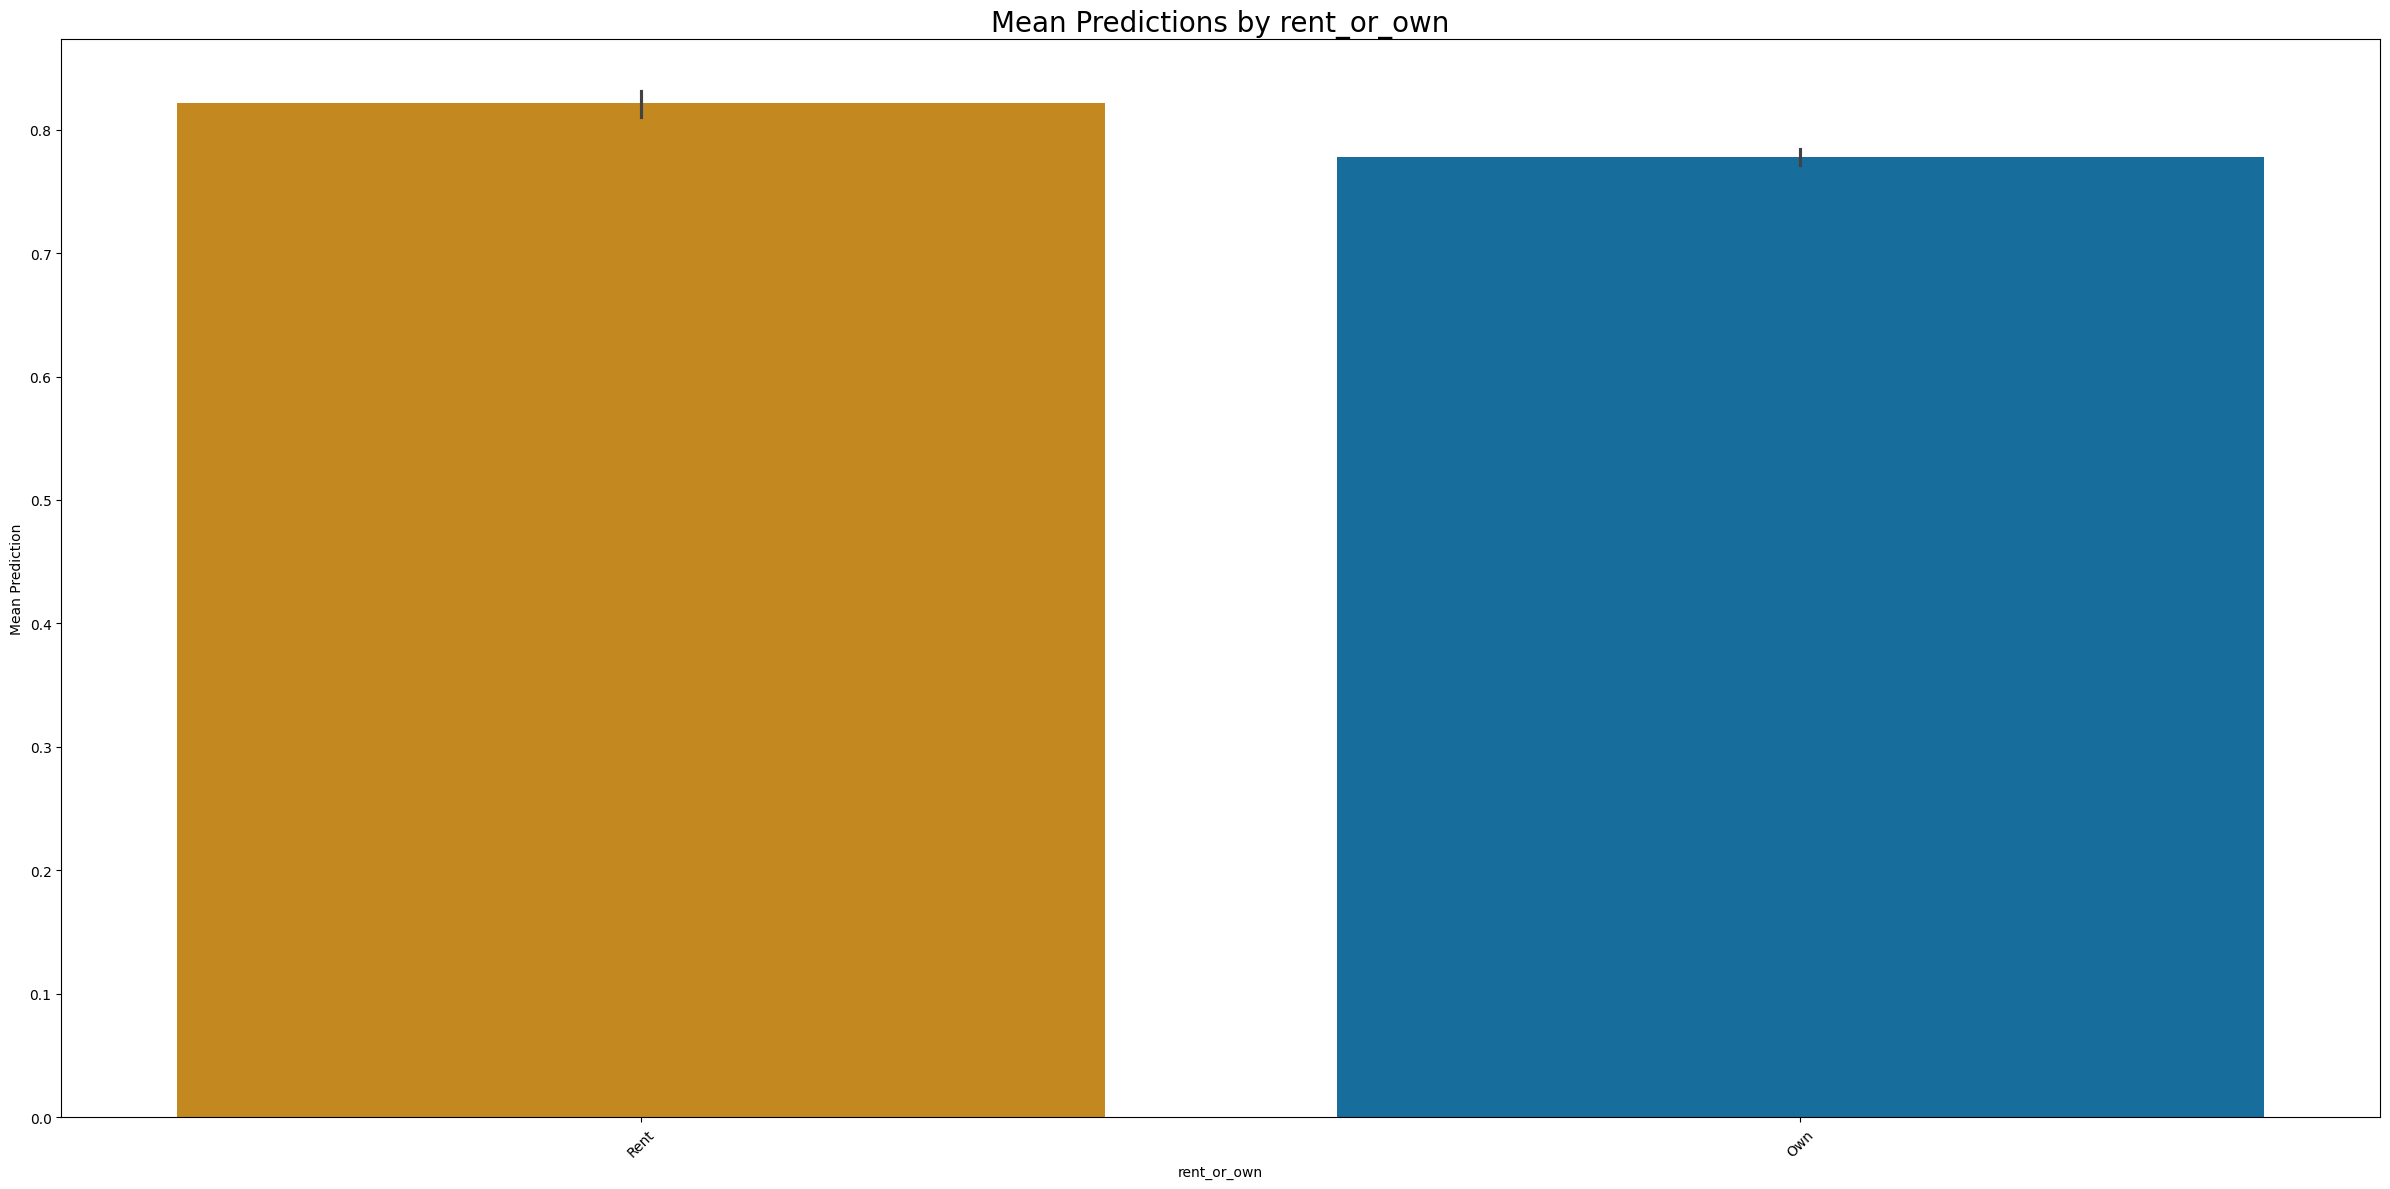

             Mean Prediction
rent_or_own                 
Rent                0.821441
Own                 0.777598


In [236]:
explore('rent_or_own')

<ipython-input-212-7d8ebd9ec1a8>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y='Predictions', data=X_preds, order=order, palette='colorblind')


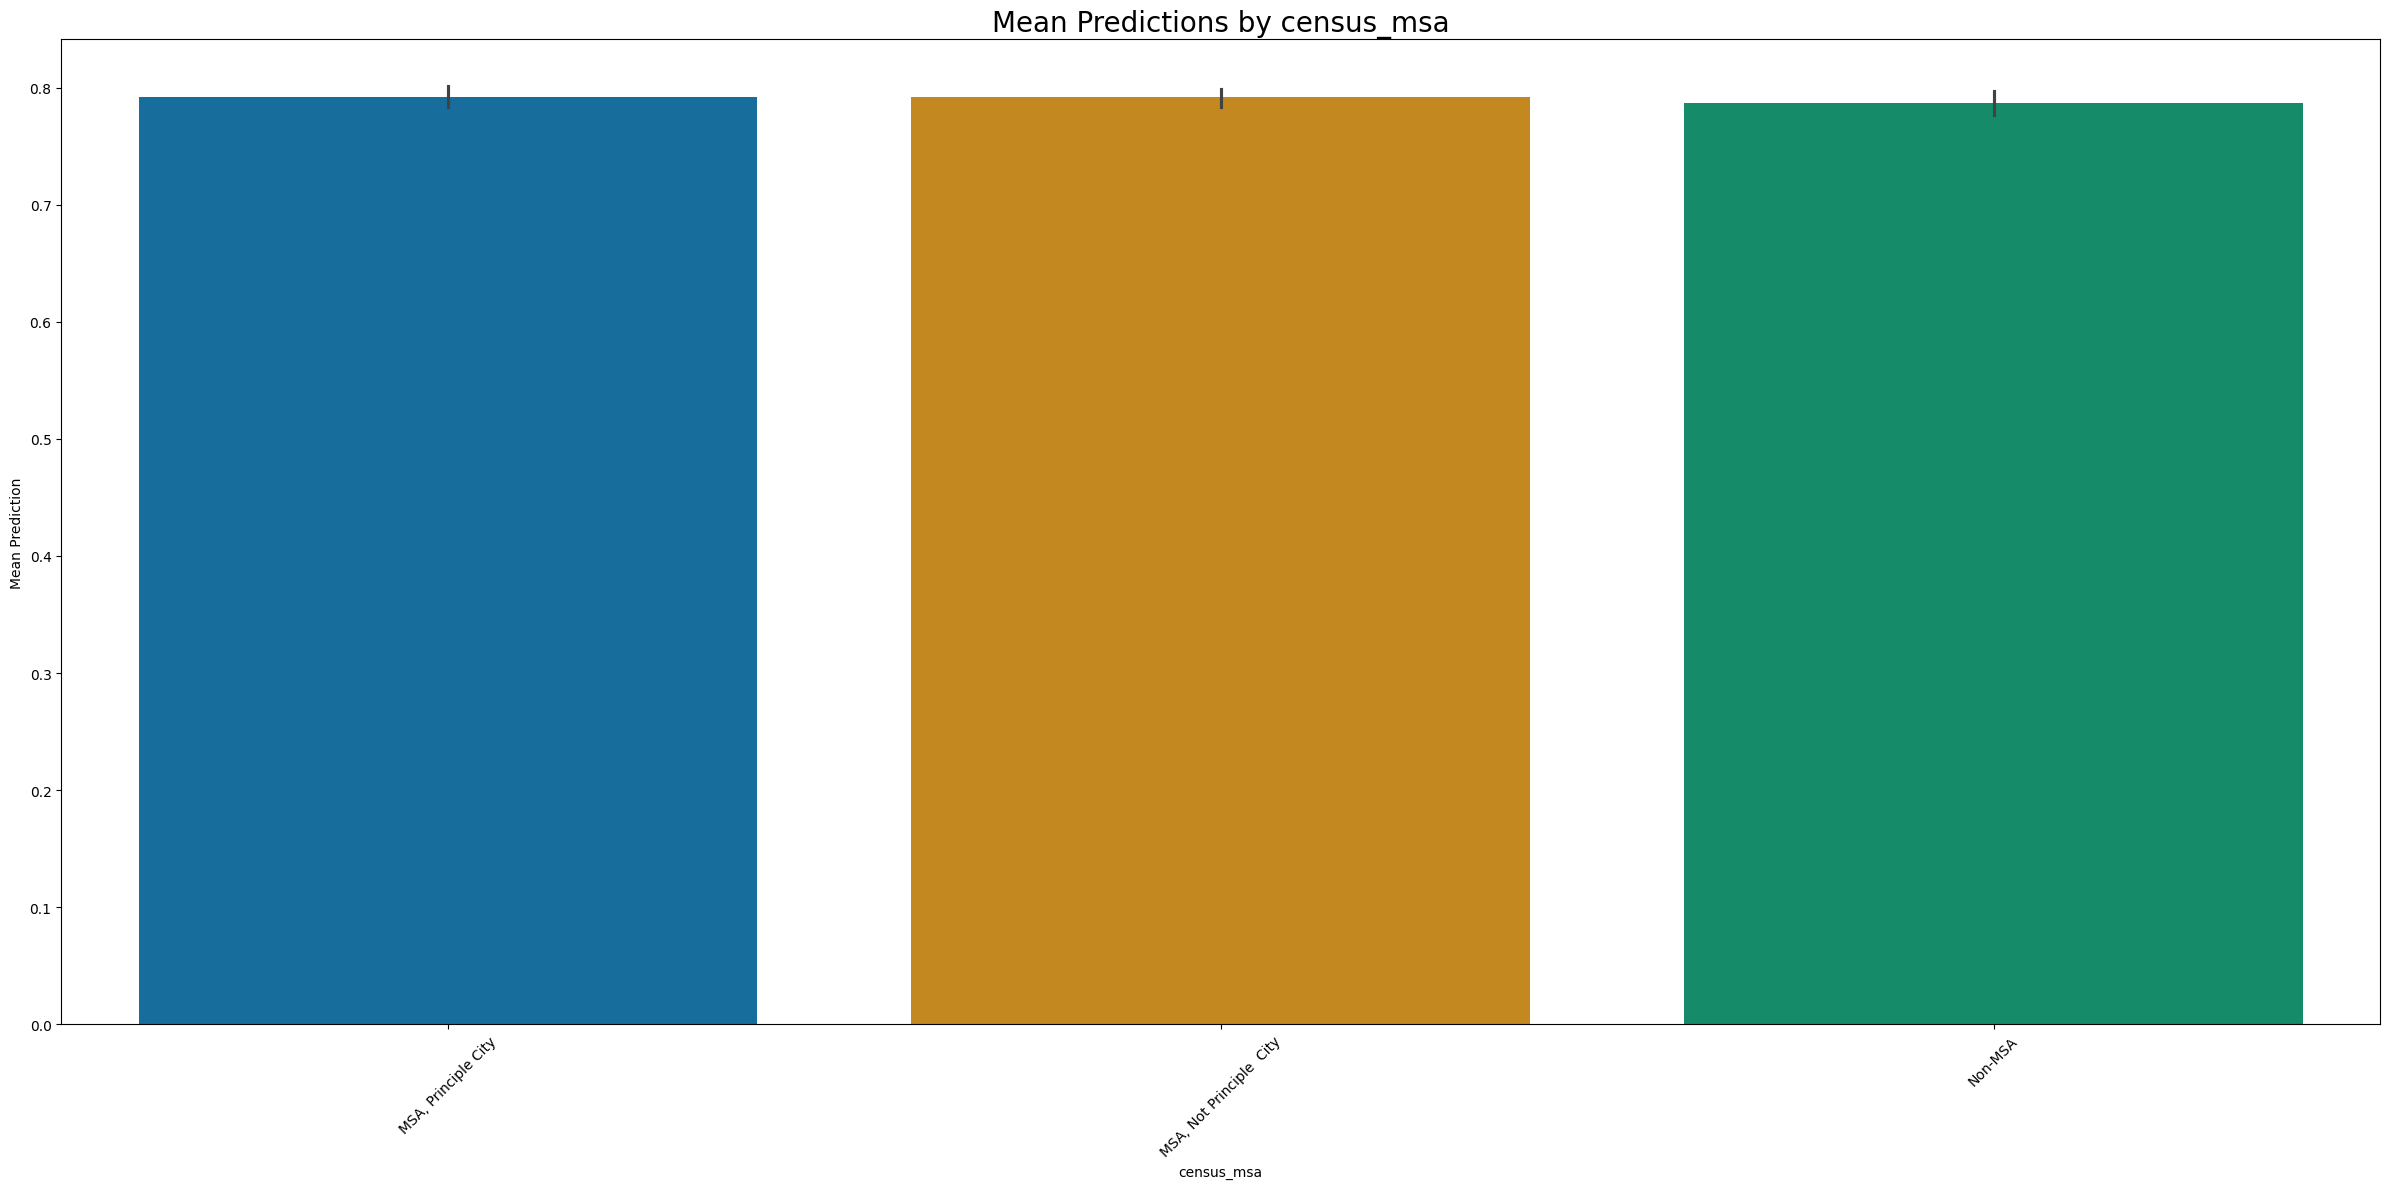

                          Mean Prediction
census_msa                               
MSA, Principle City              0.792179
MSA, Not Principle  City         0.791785
Non-MSA                          0.786707


In [217]:
explore('census_msa')

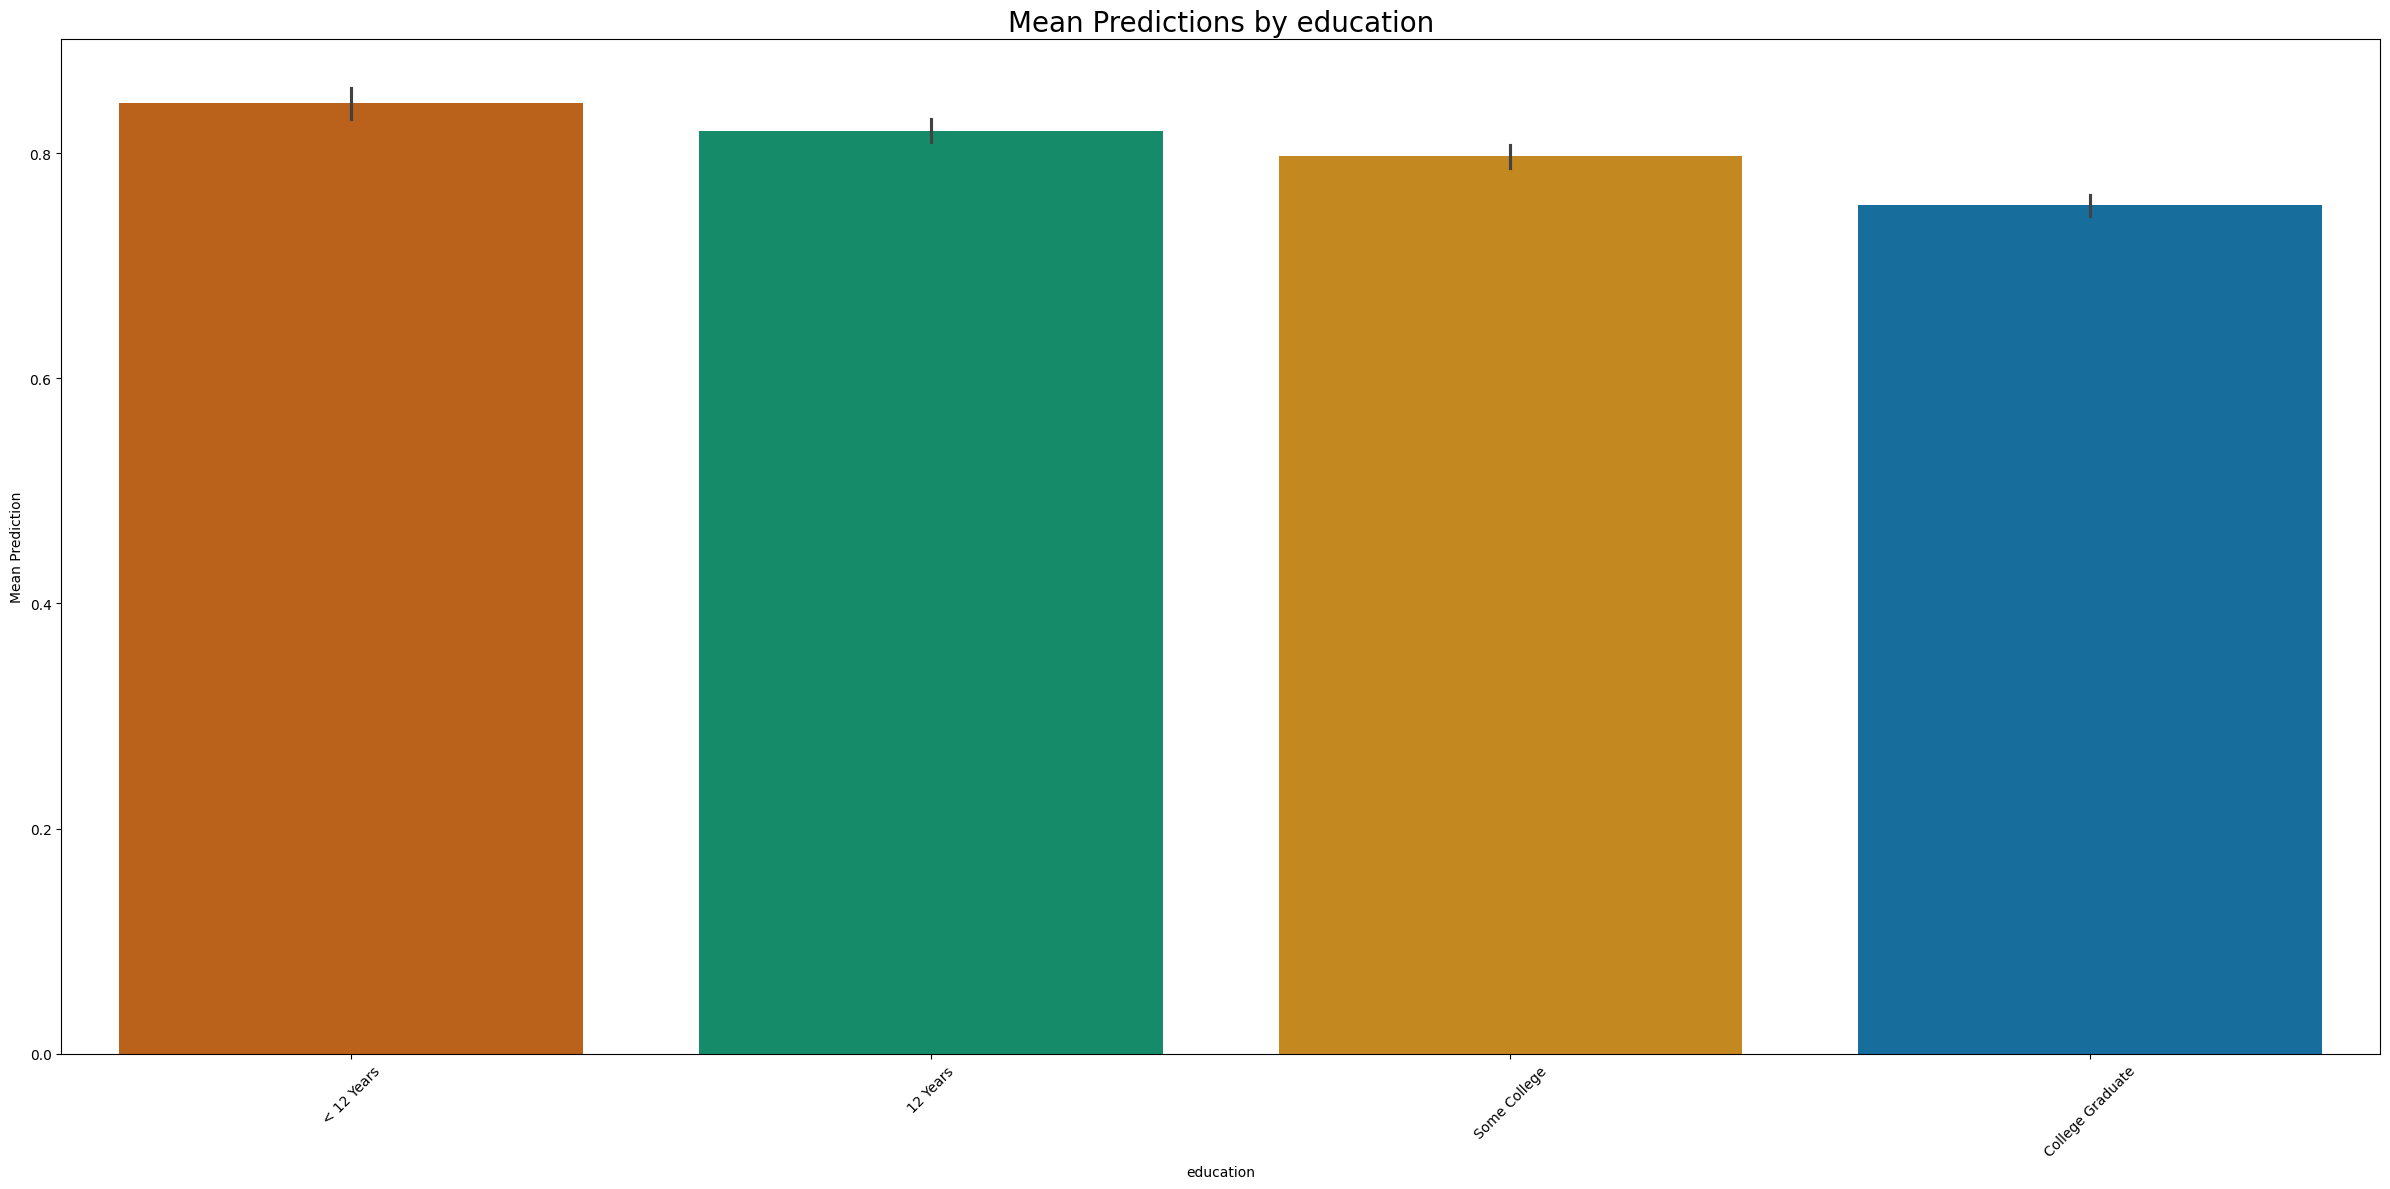

                  Mean Prediction
education                        
< 12 Years               0.844539
12 Years                 0.819490
Some College             0.797265
College Graduate         0.753720


In [237]:
explore('education')

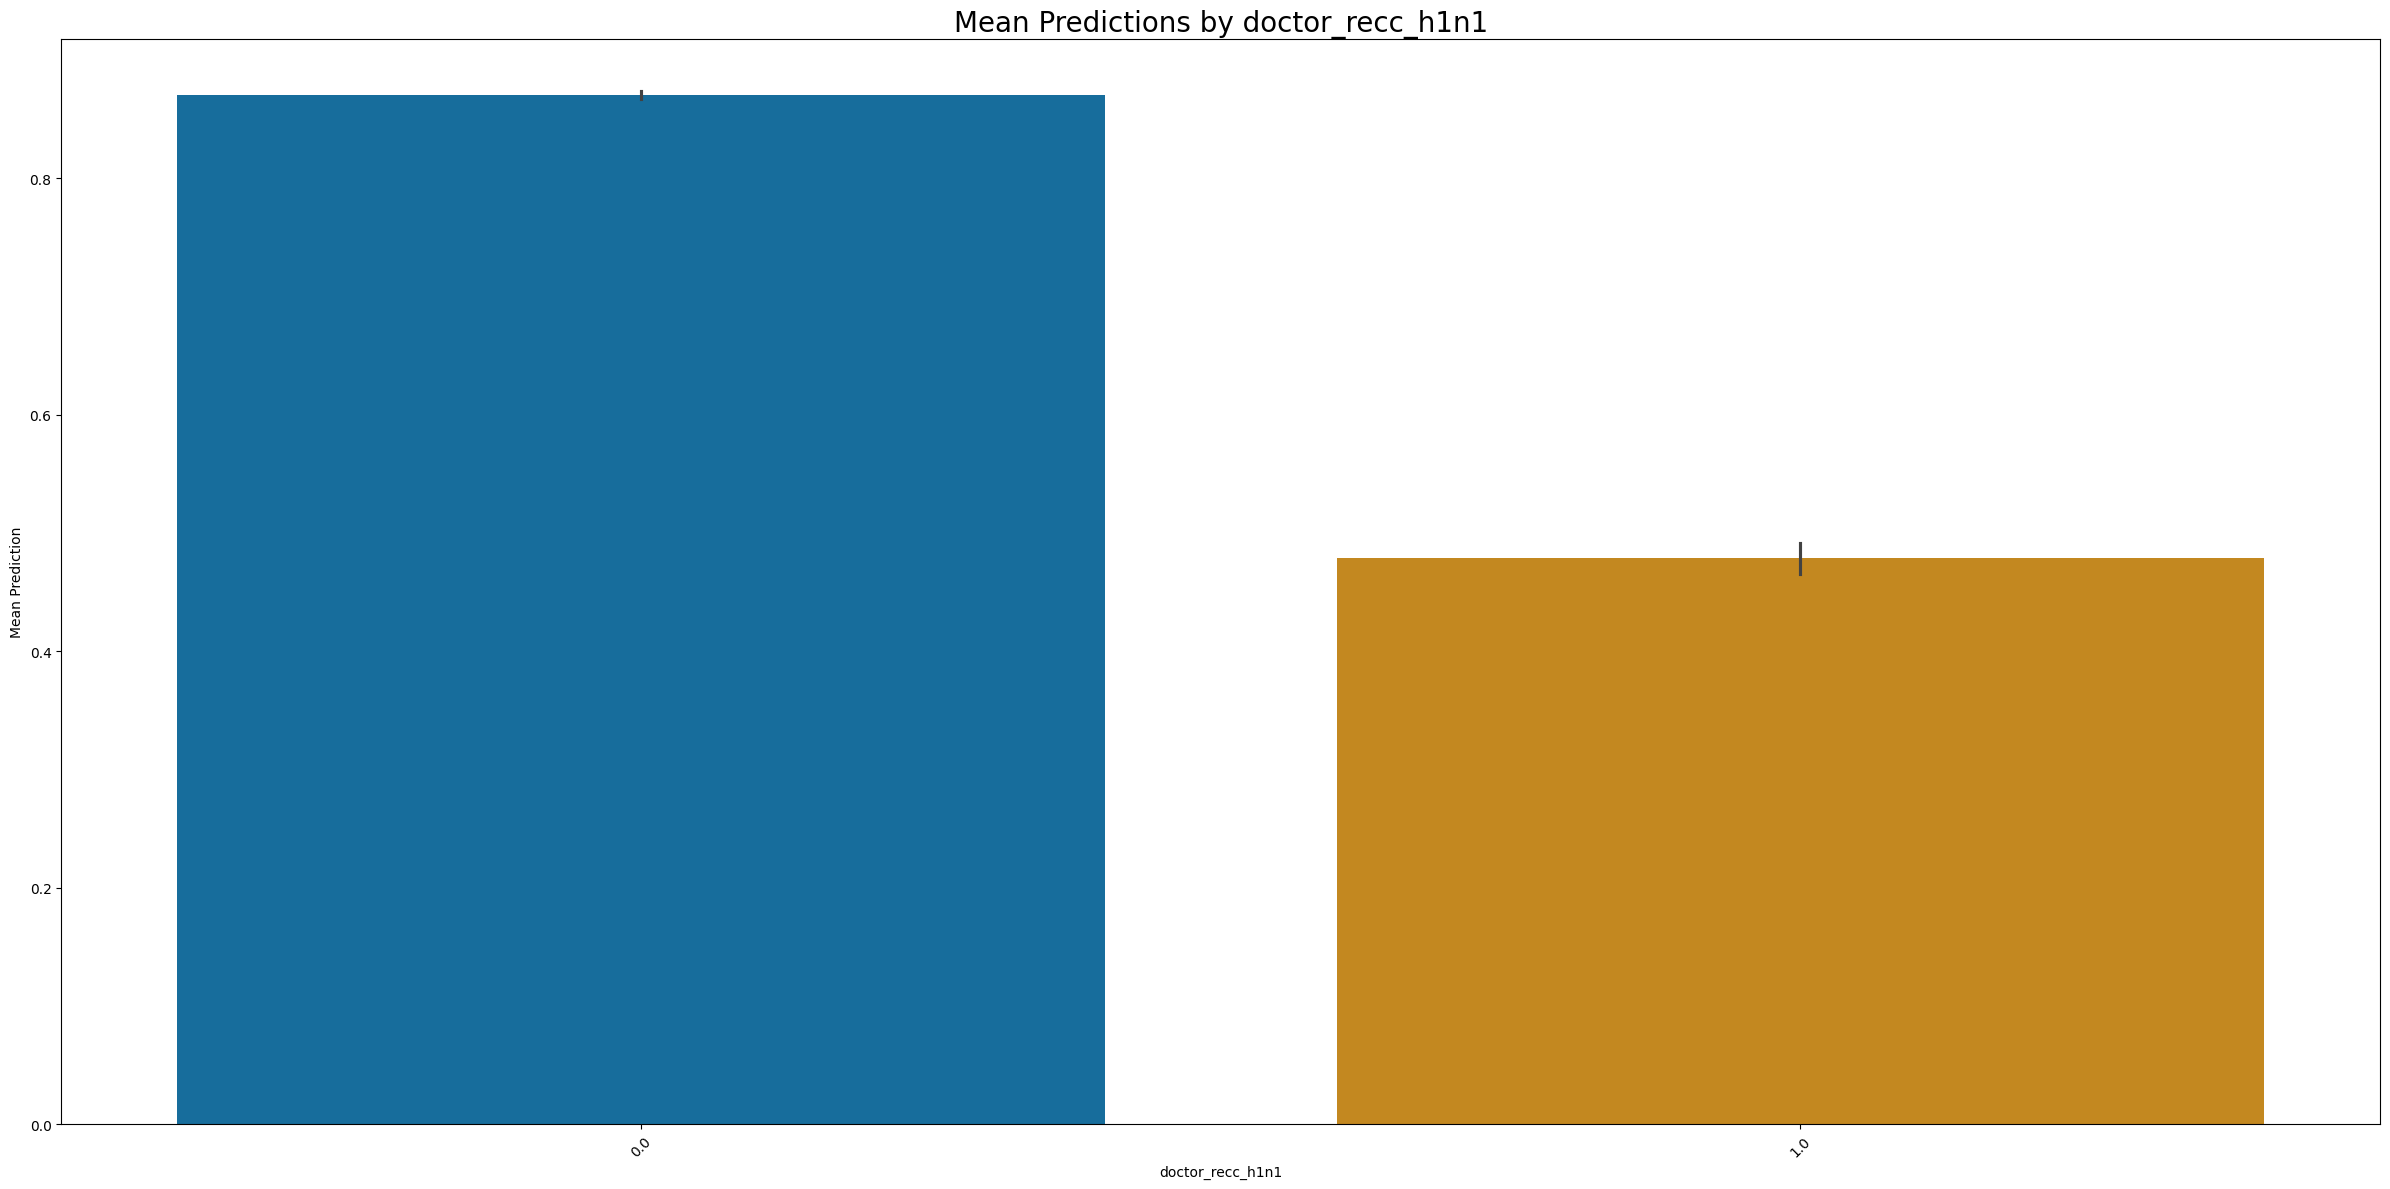

                  Mean Prediction
doctor_recc_h1n1                 
0.0                      0.870175
1.0                      0.478606


In [238]:
explore('doctor_recc_h1n1')

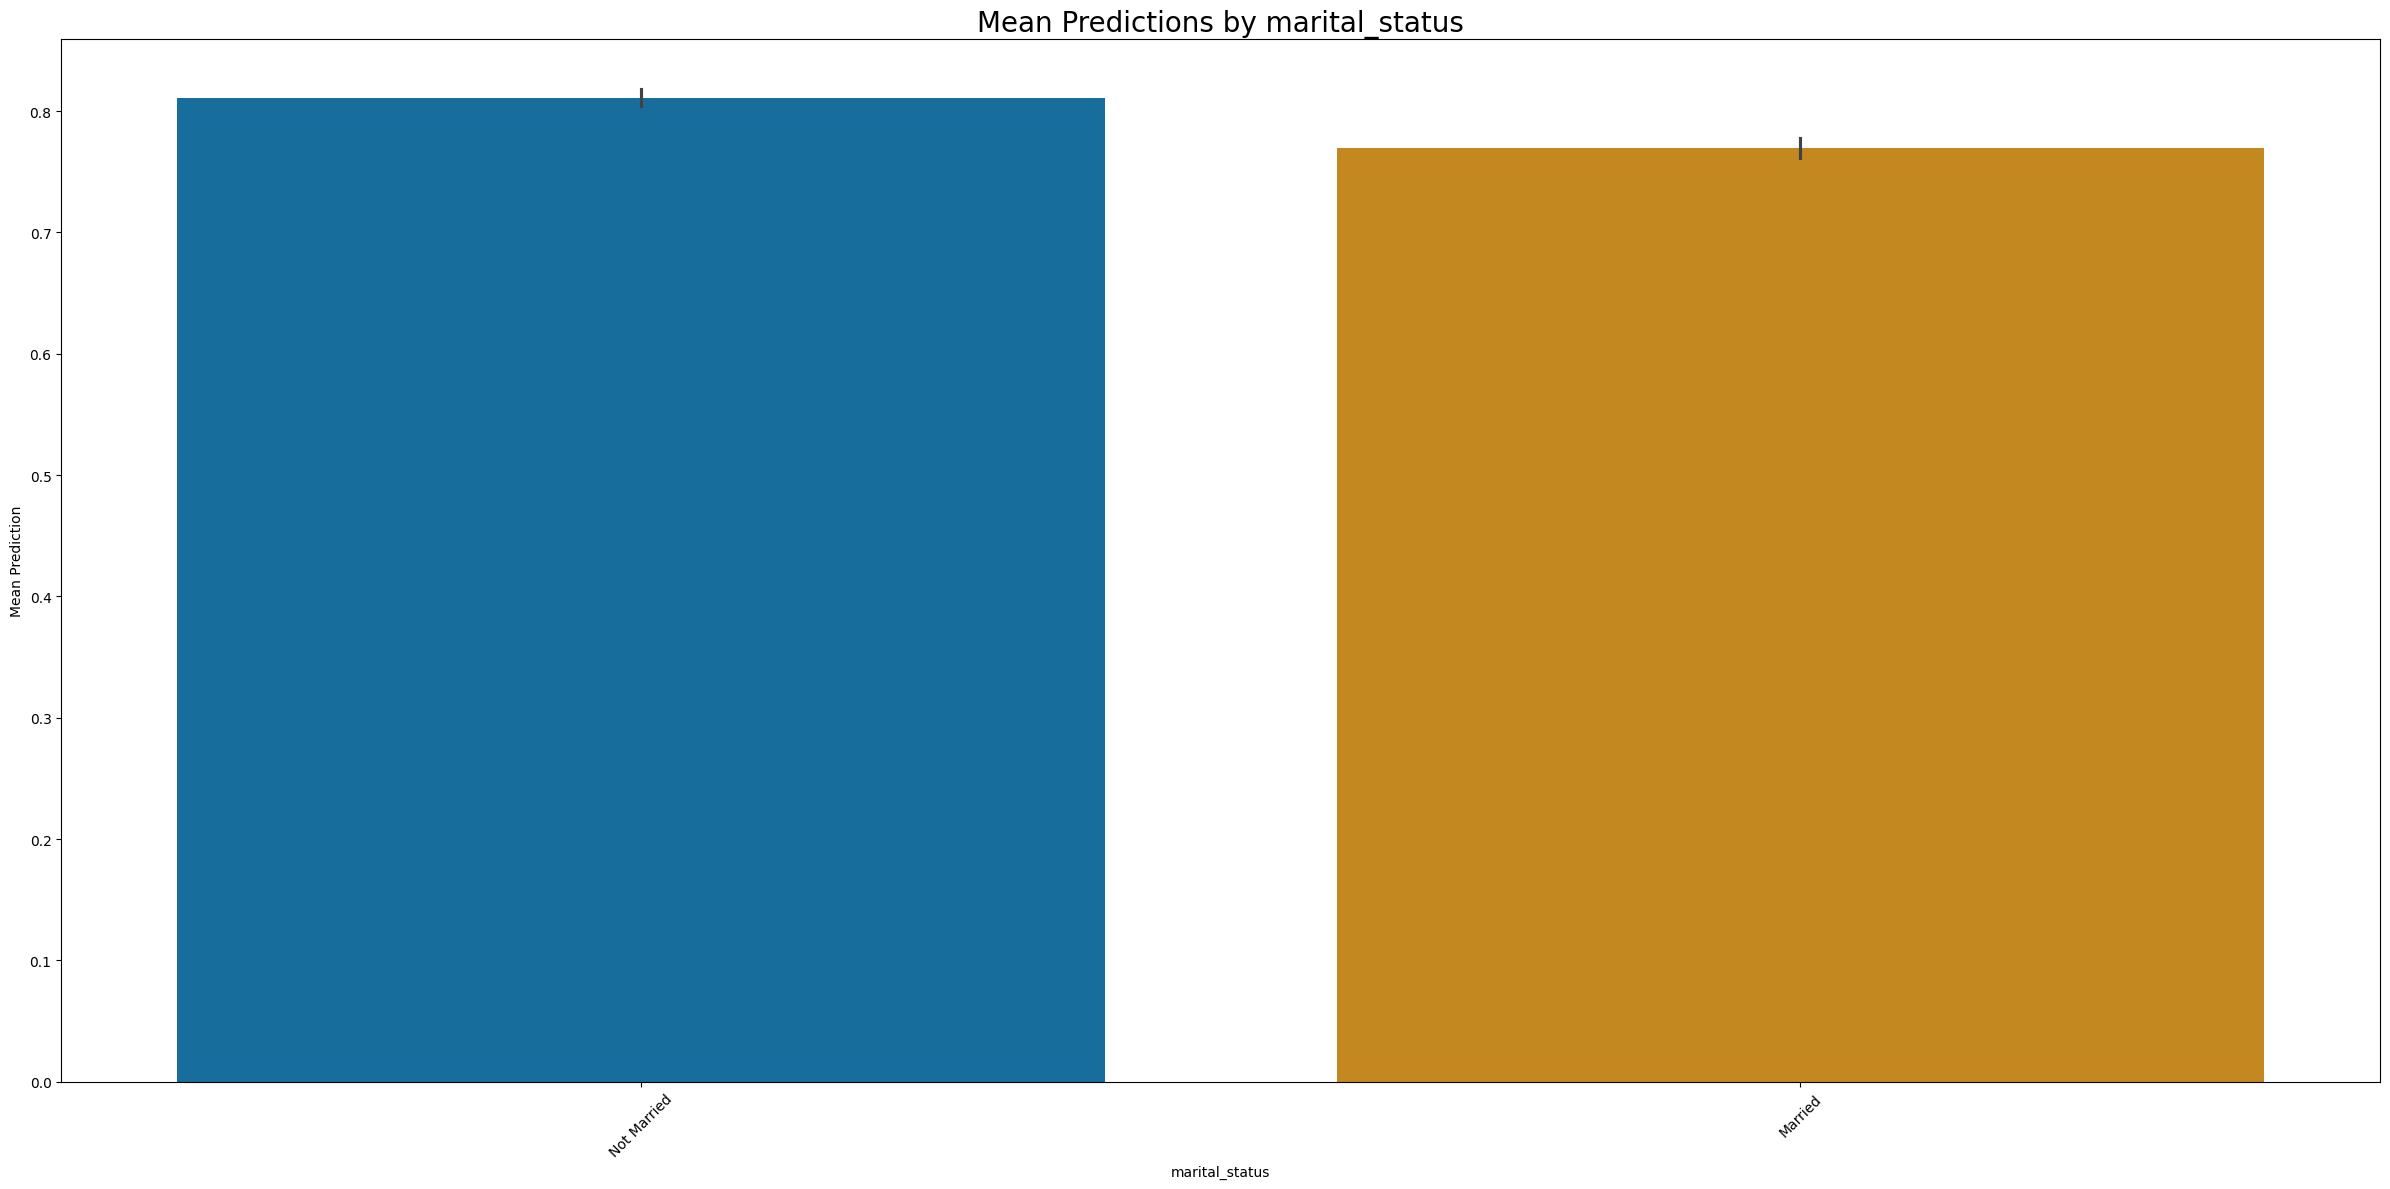

                Mean Prediction
marital_status                 
Not Married            0.810965
Married                0.769887


In [239]:
explore('marital_status')

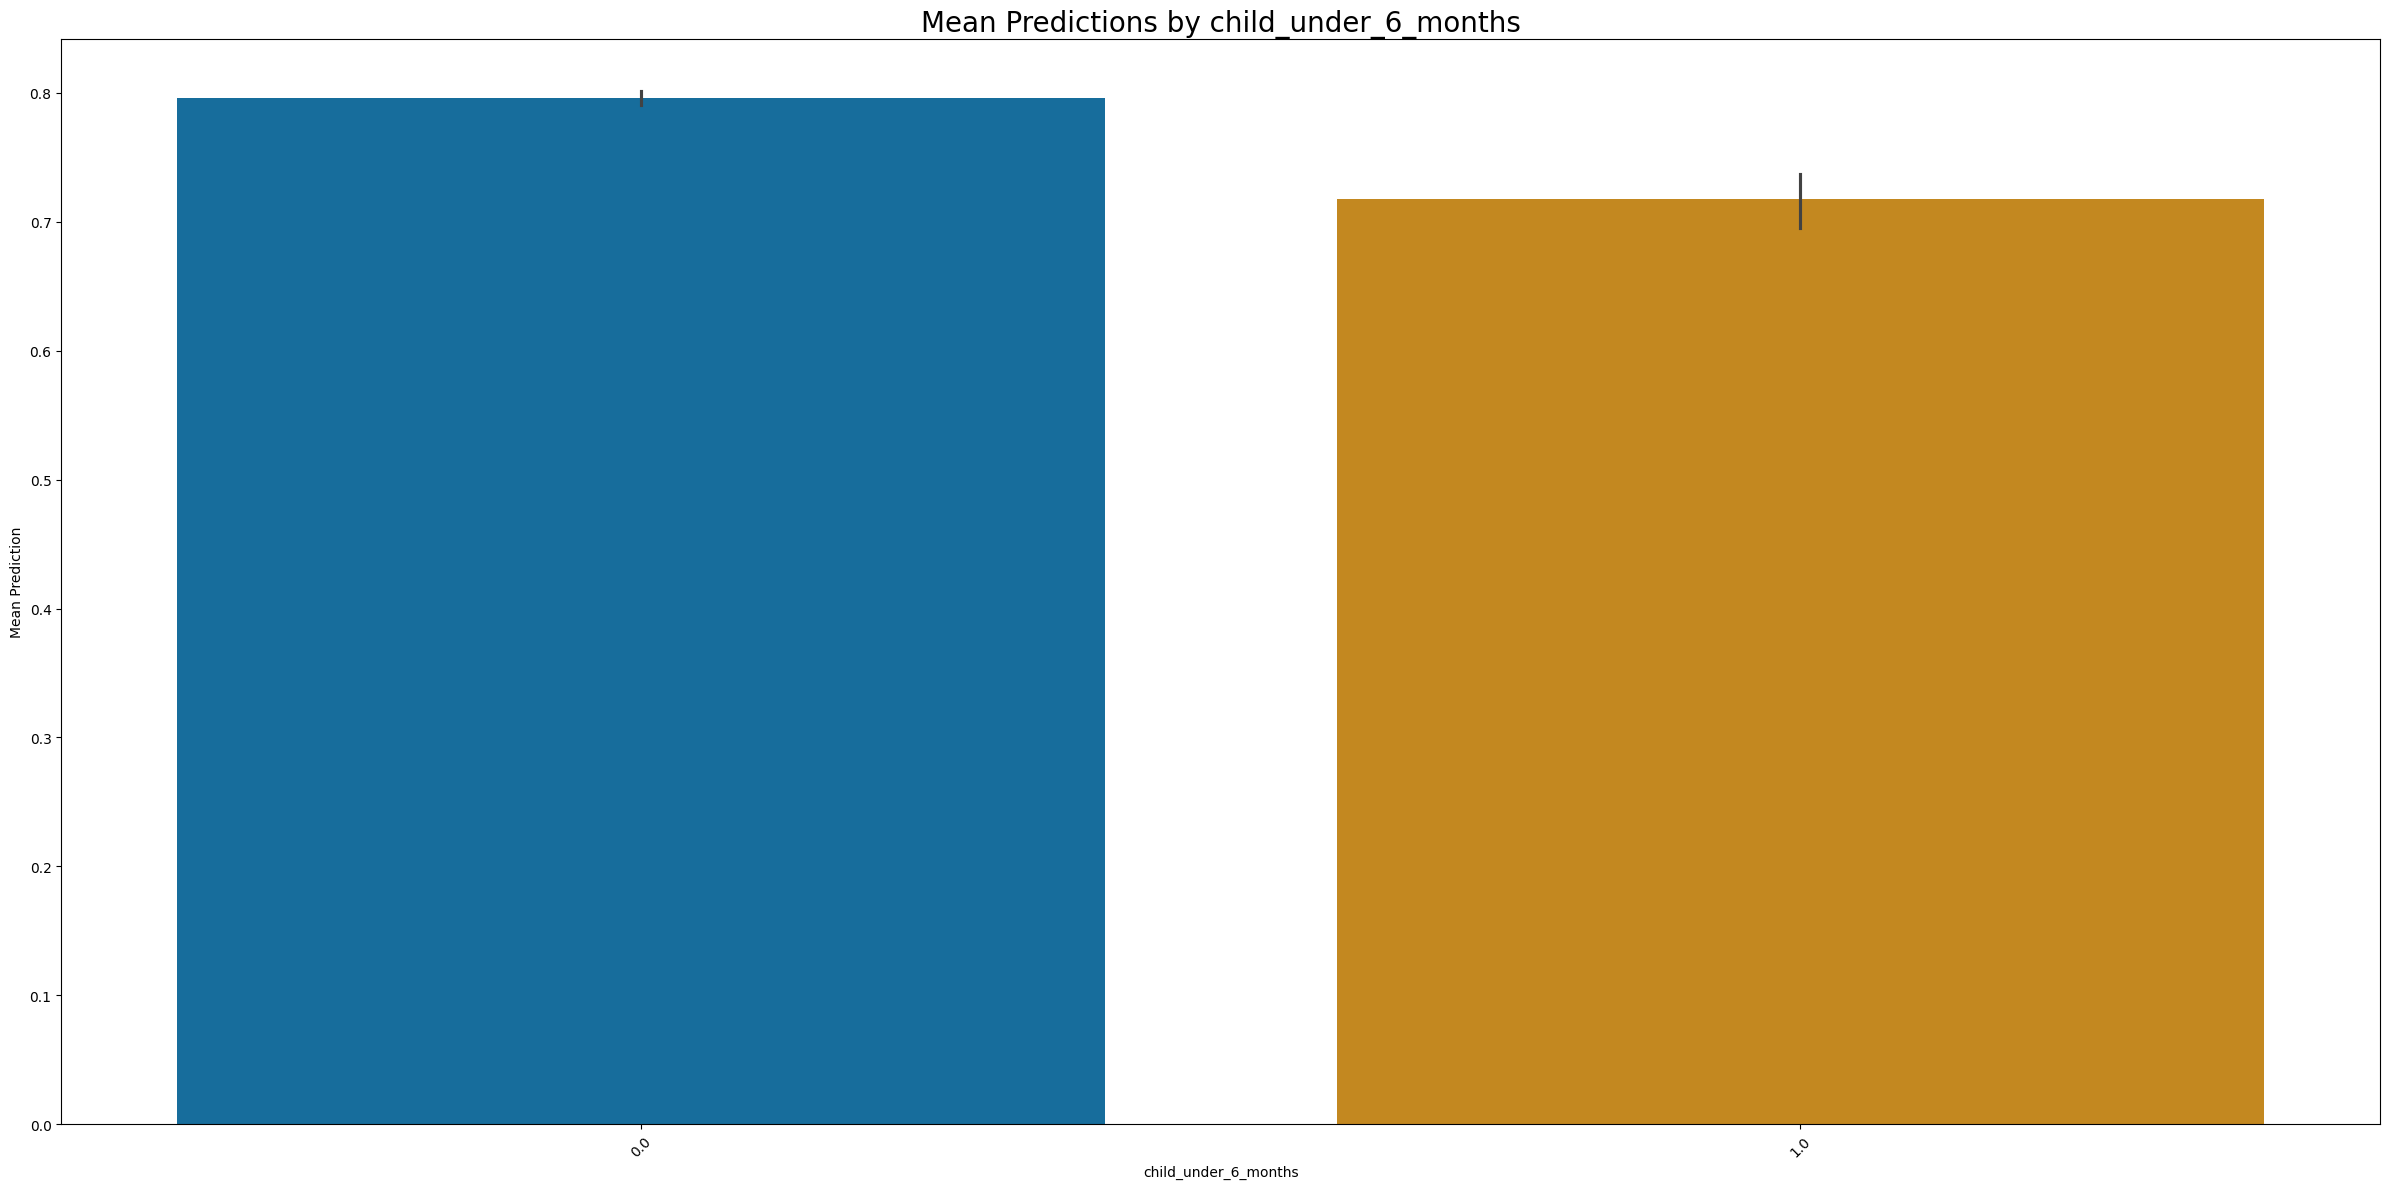

                      Mean Prediction
child_under_6_months                 
0.0                          0.795891
1.0                          0.717344


In [240]:
explore('child_under_6_months')


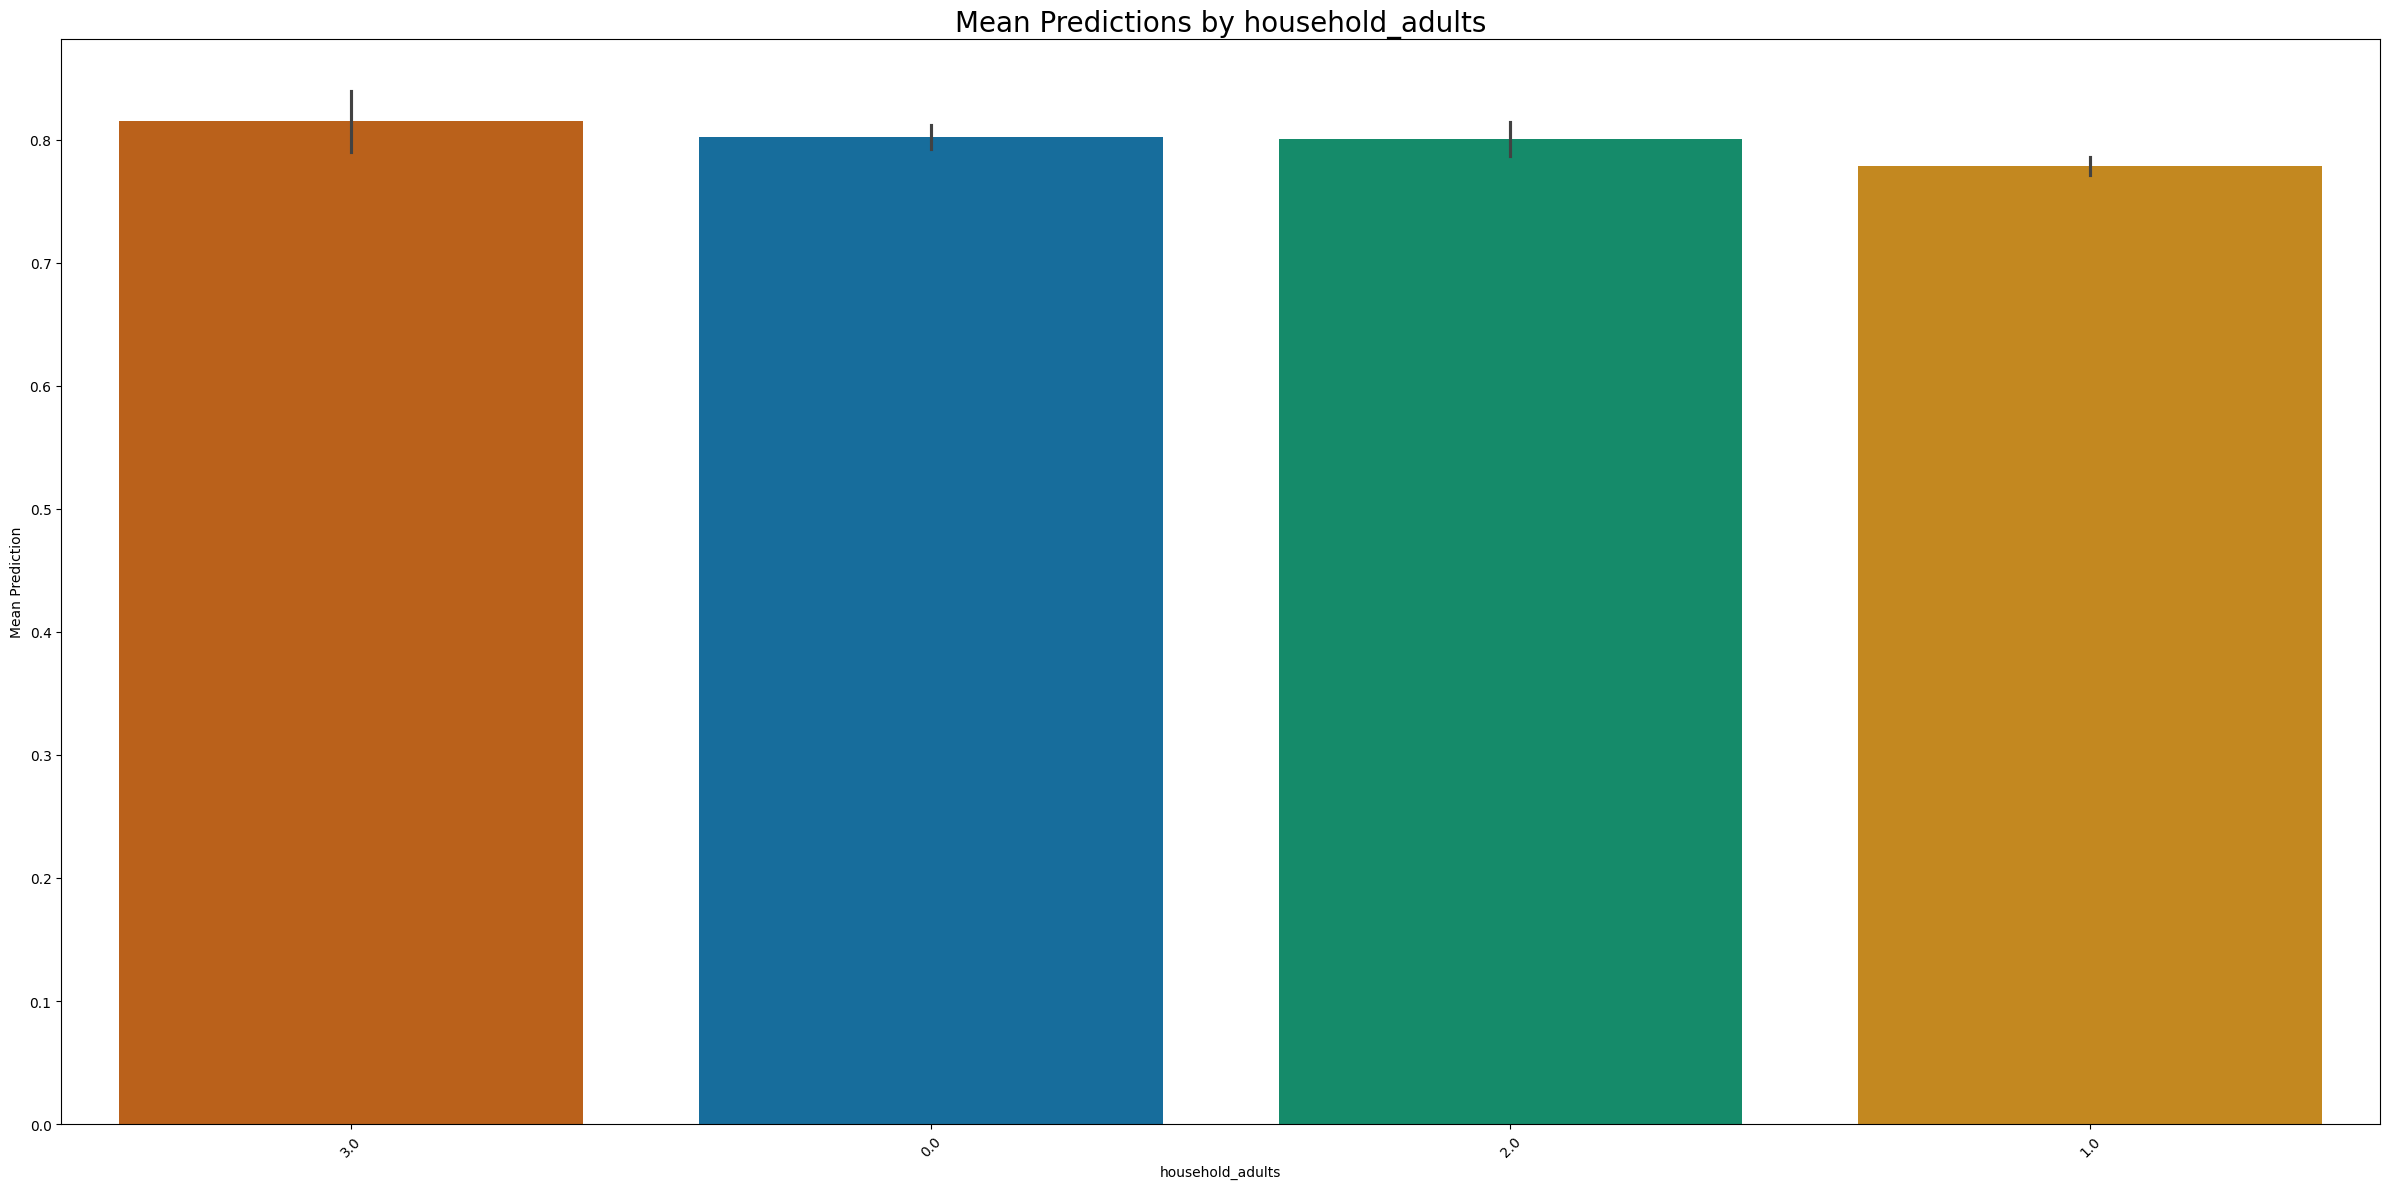

                  Mean Prediction
household_adults                 
3.0                      0.814994
0.0                      0.802304
2.0                      0.800687
1.0                      0.778434


In [241]:
explore('household_adults')

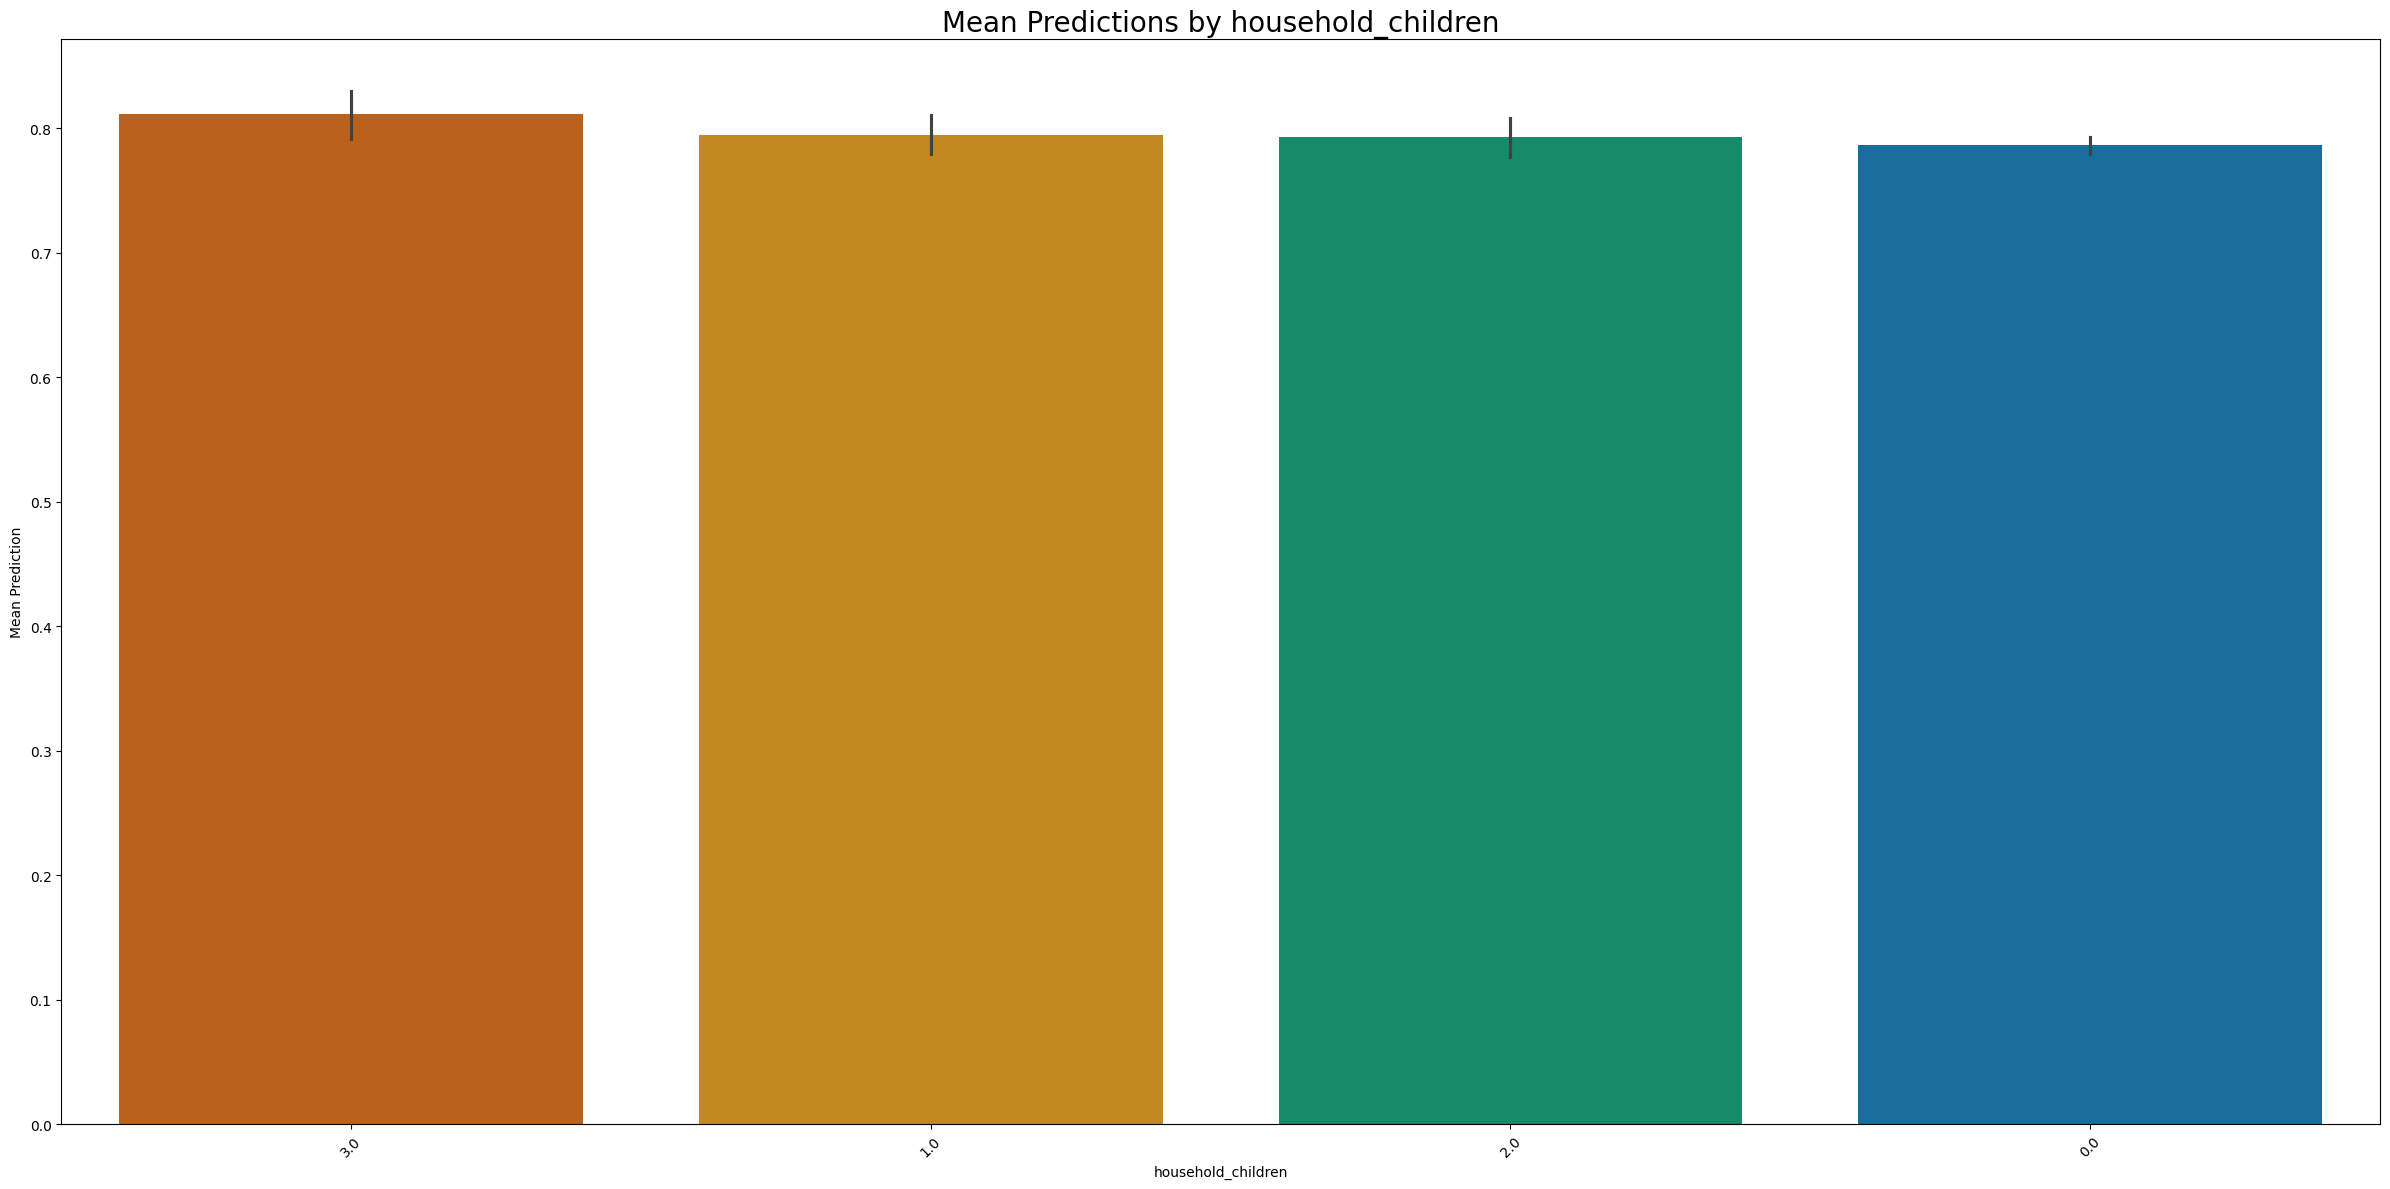

                    Mean Prediction
household_children                 
3.0                        0.811314
1.0                        0.794767
2.0                        0.793010
0.0                        0.786627


In [242]:
explore('household_children')

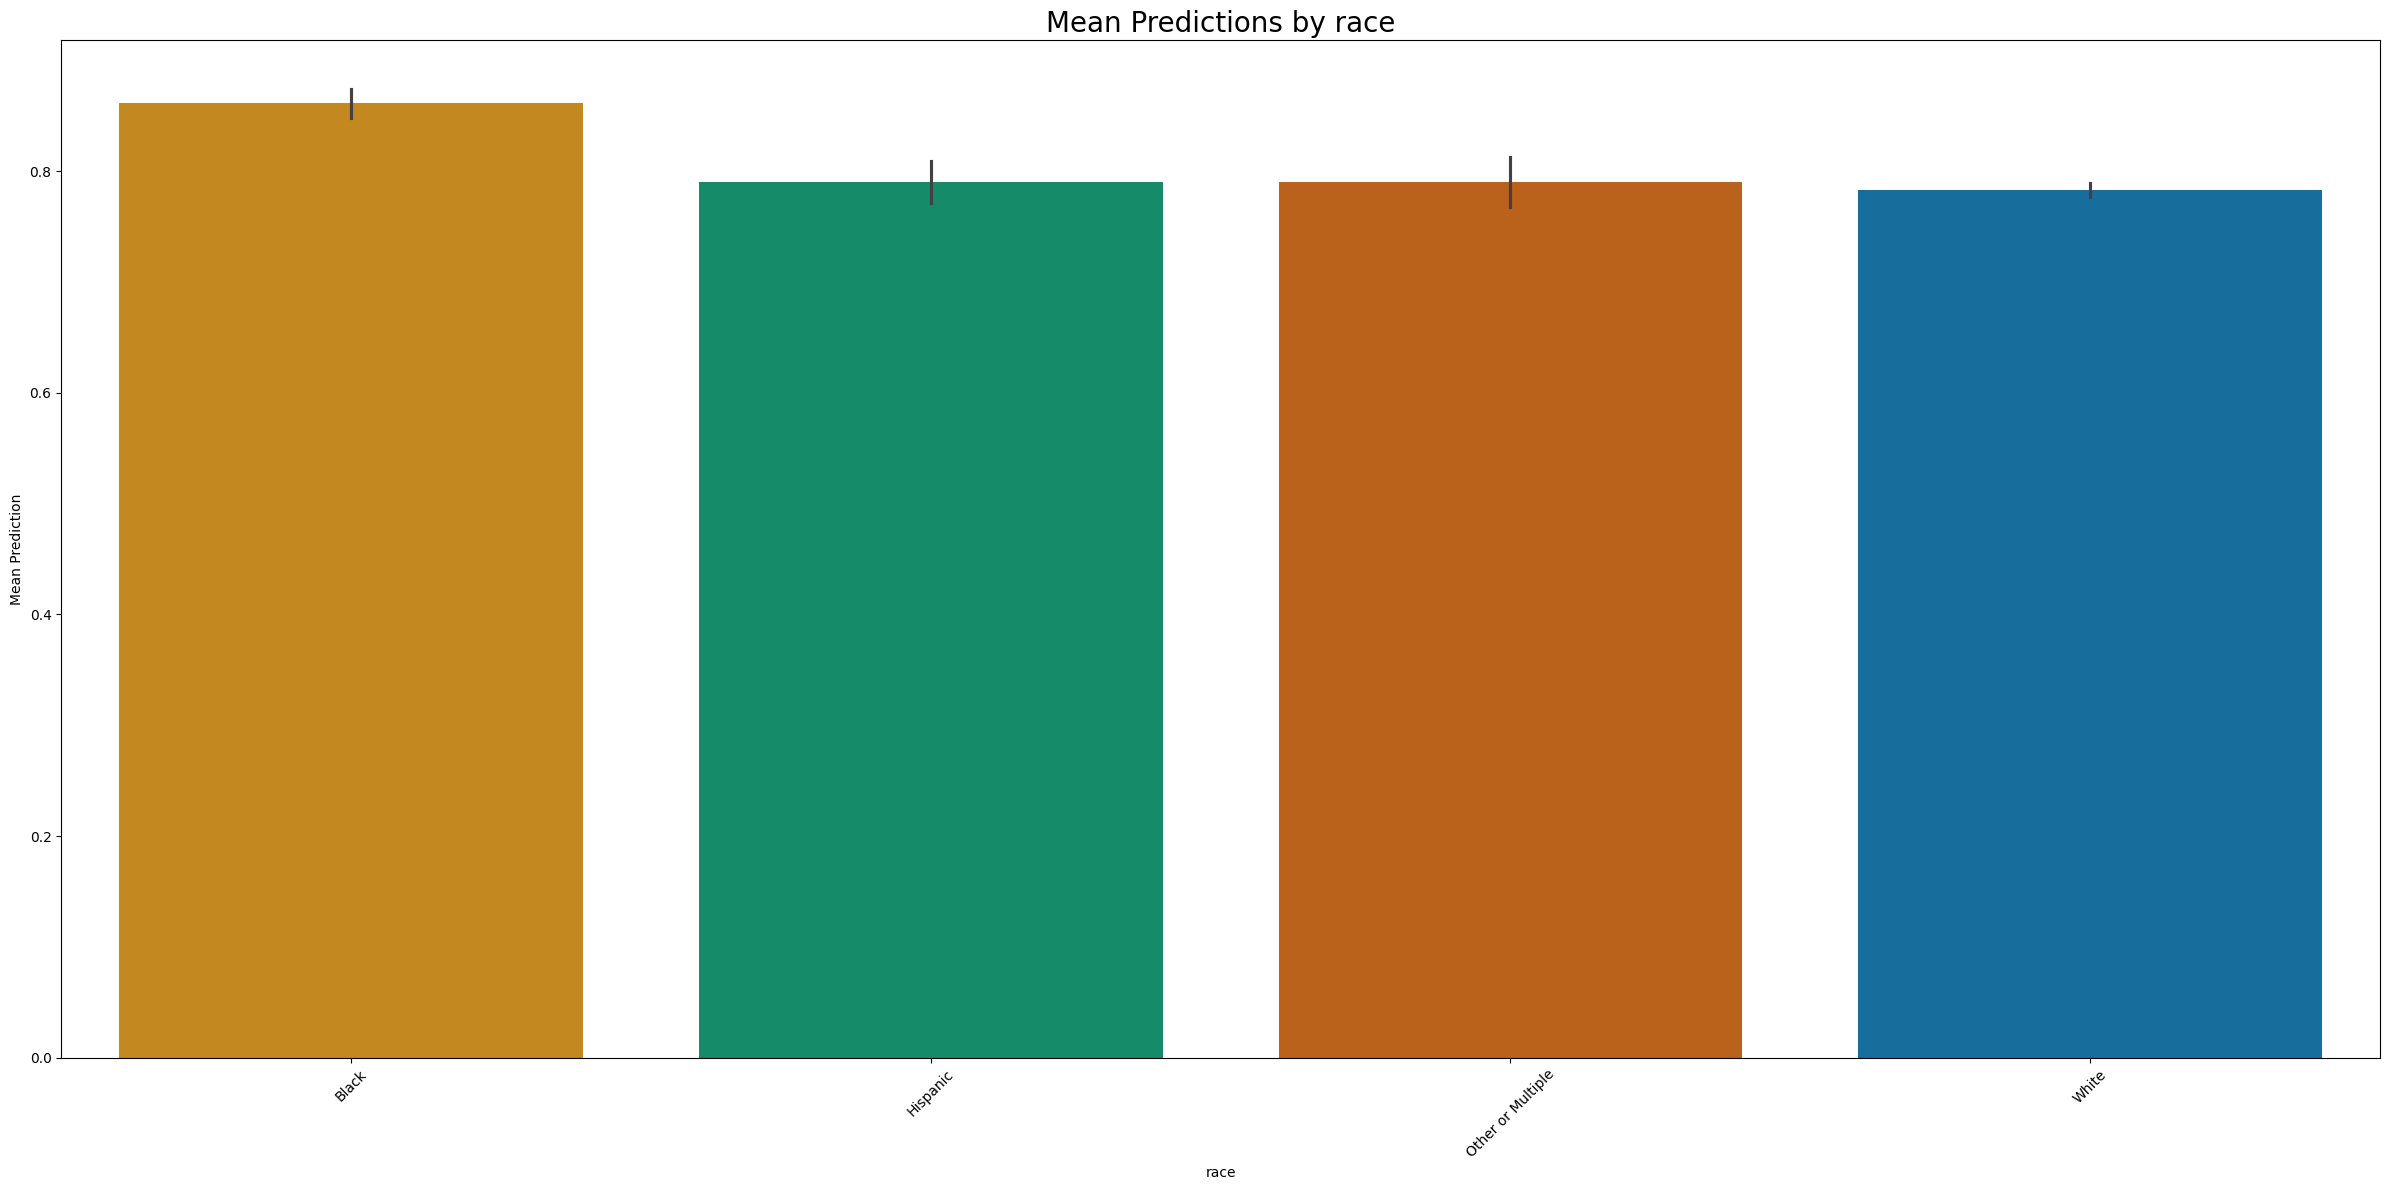

                   Mean Prediction
race                              
Black                     0.861268
Hispanic                  0.790062
Other or Multiple         0.790049
White                     0.782835


In [243]:
explore('race')

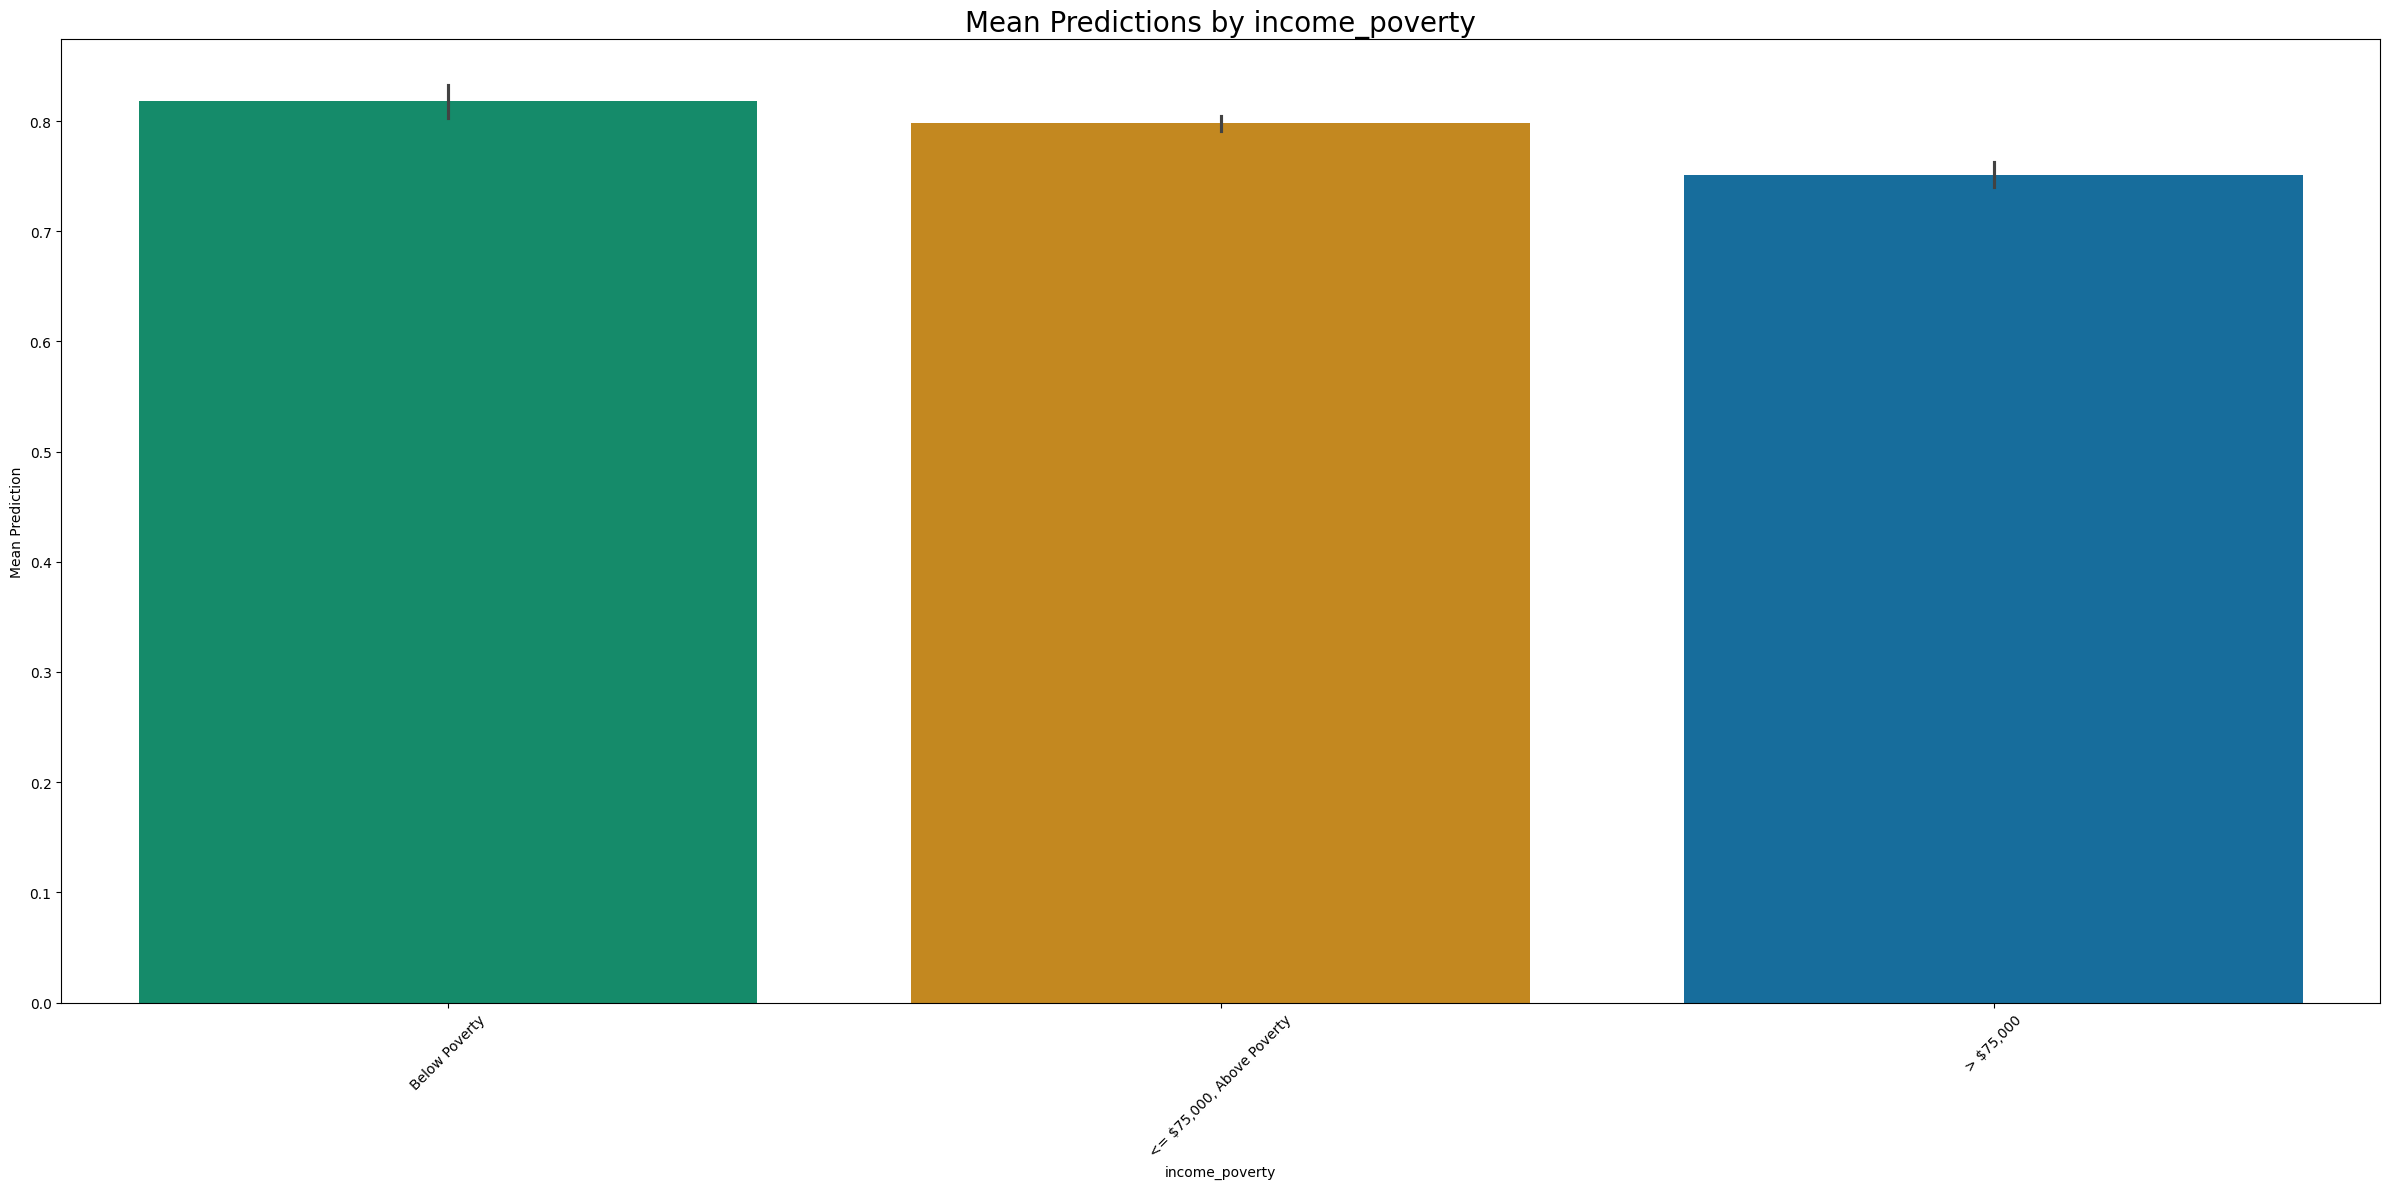

                           Mean Prediction
income_poverty                            
Below Poverty                     0.818398
<= $75,000, Above Poverty         0.798004
> $75,000                         0.751495


In [244]:
explore('income_poverty')

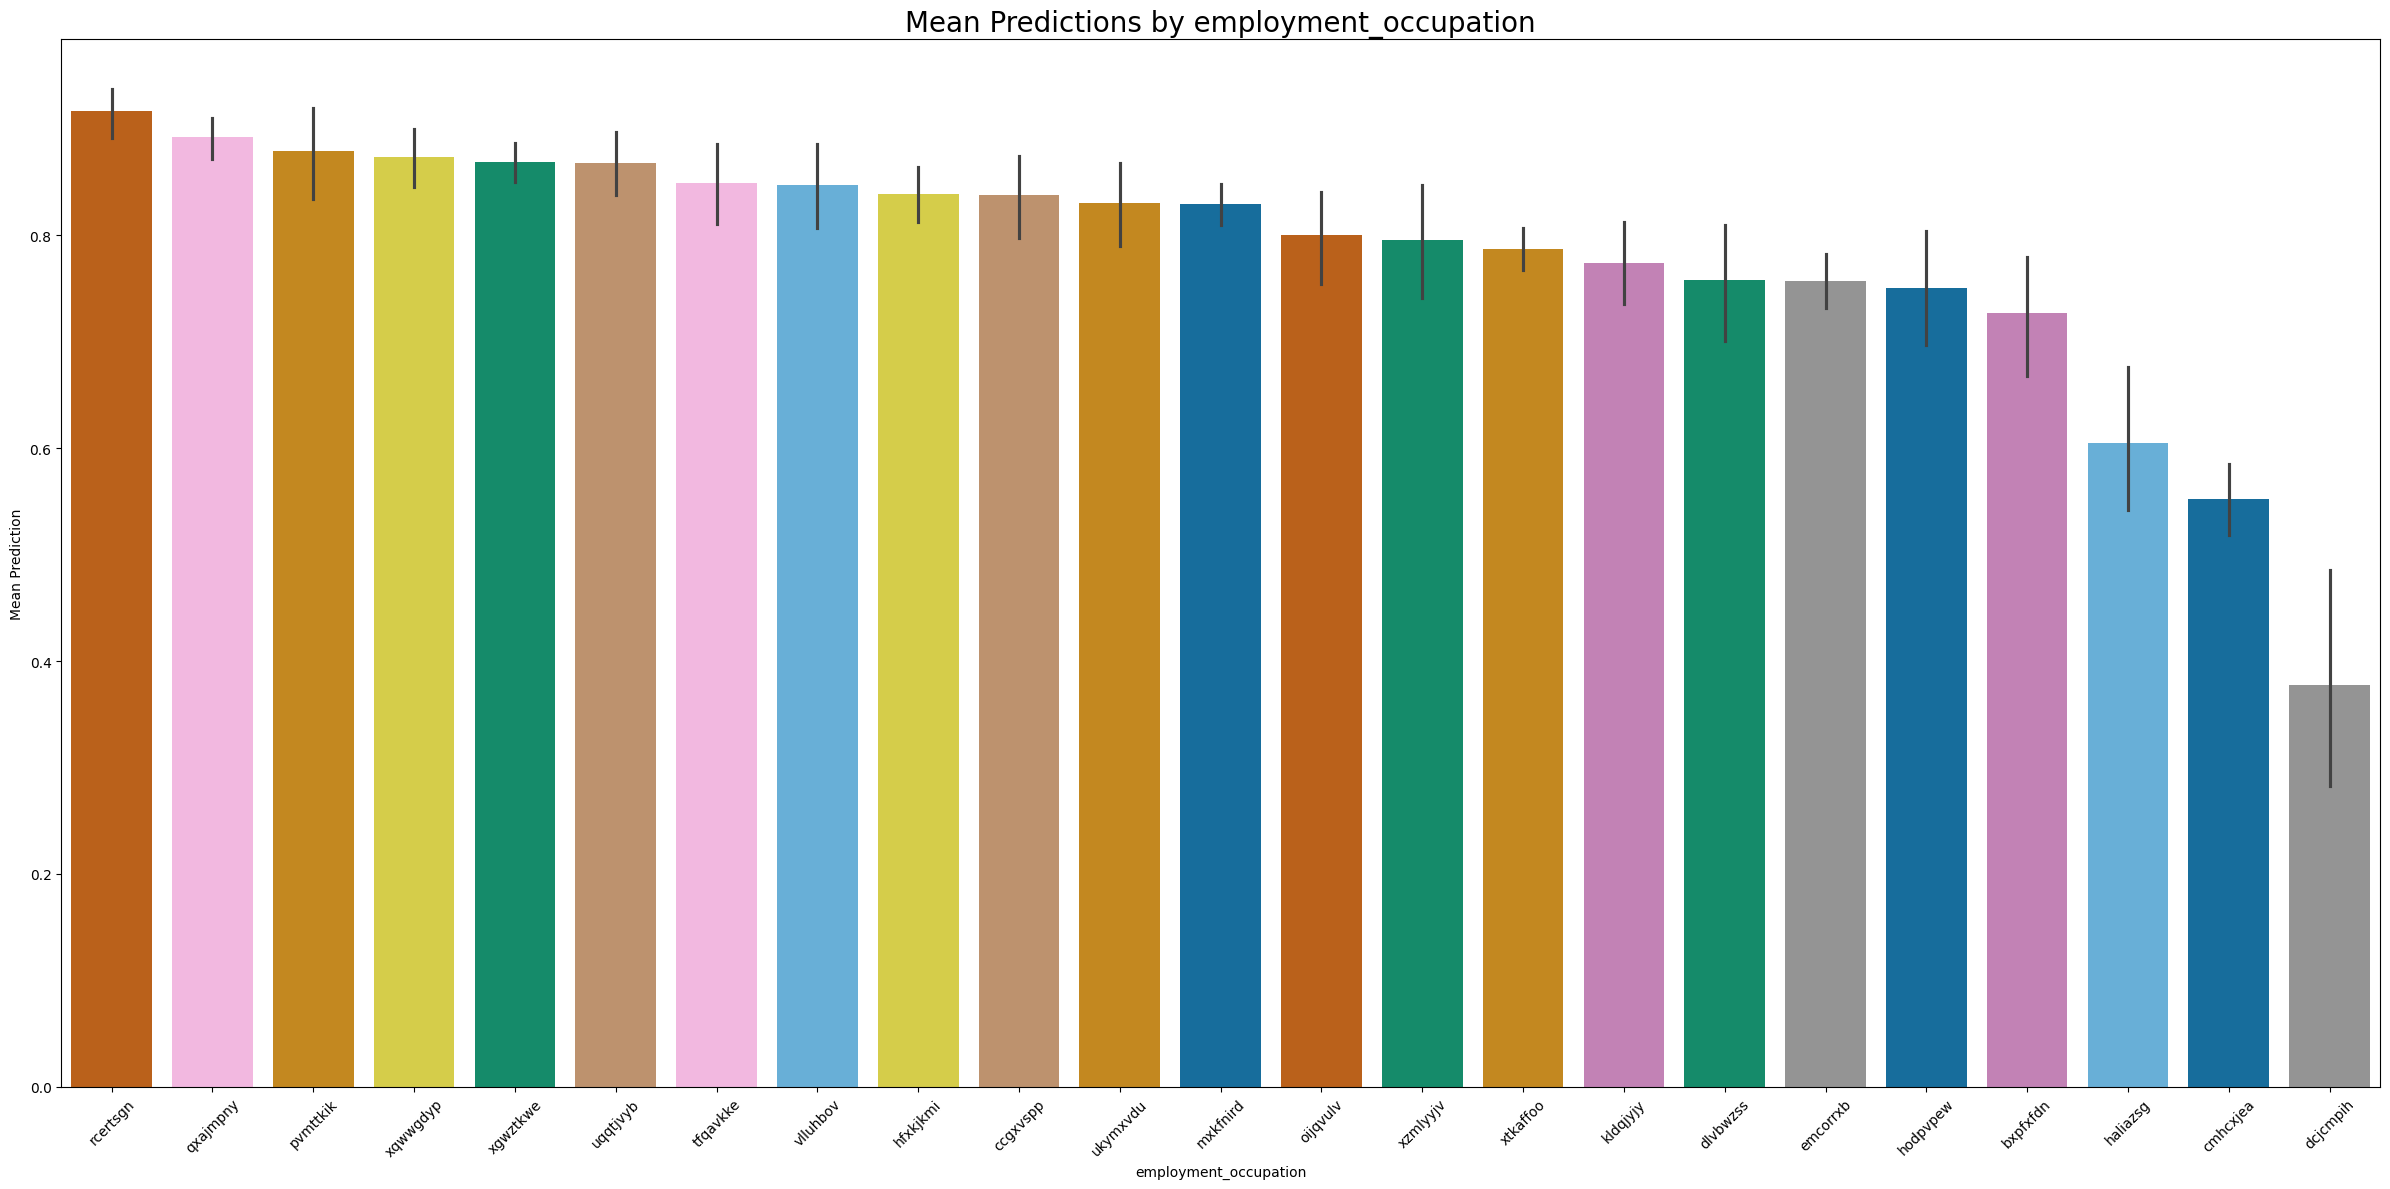

                       Mean Prediction
employment_occupation                 
rcertsgn                      0.916640
qxajmpny                      0.892636
pvmttkik                      0.879348
xqwwgdyp                      0.873470
xgwztkwe                      0.869078
uqqtjvyb                      0.868381
tfqavkke                      0.849376
vlluhbov                      0.847692
hfxkjkmi                      0.839330
ccgxvspp                      0.837829
ukymxvdu                      0.830119
mxkfnird                      0.829243
oijqvulv                      0.800480
xzmlyyjv                      0.795799
xtkaffoo                      0.787284
kldqjyjy                      0.774539
dlvbwzss                      0.758015
emcorrxb                      0.757044
hodpvpew                      0.750626
bxpfxfdn                      0.727040
haliazsg                      0.604832
cmhcxjea                      0.552797
dcjcmpih                      0.377872


In [245]:
explore('employment_occupation')
#coded in random strings for privacy purposes

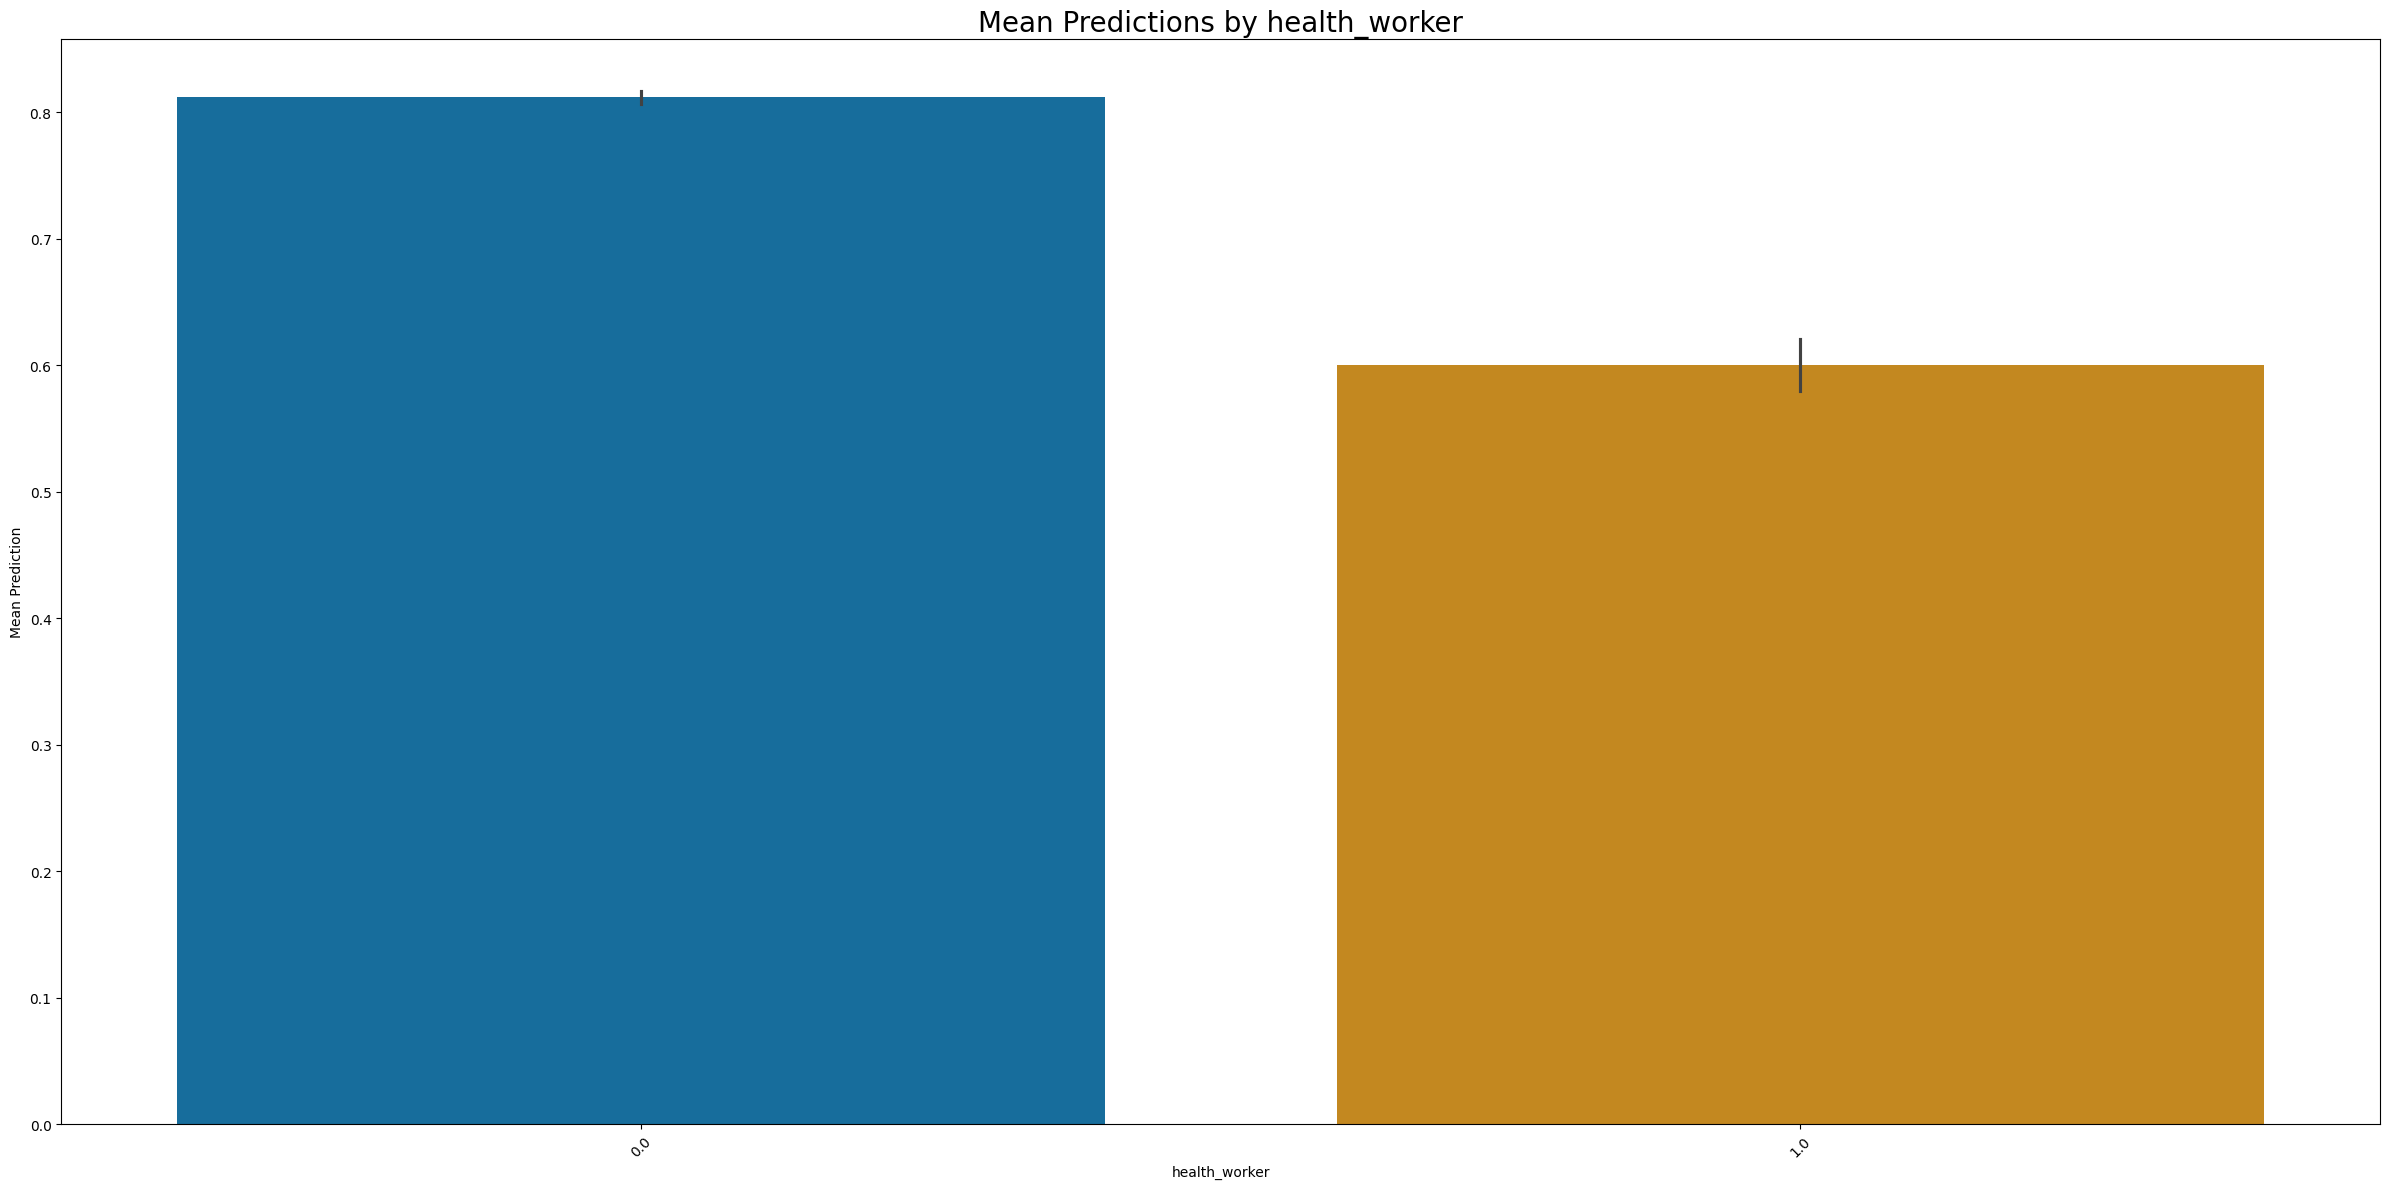

               Mean Prediction
health_worker                 
0.0                   0.811763
1.0                   0.600038


In [246]:
explore('health_worker')

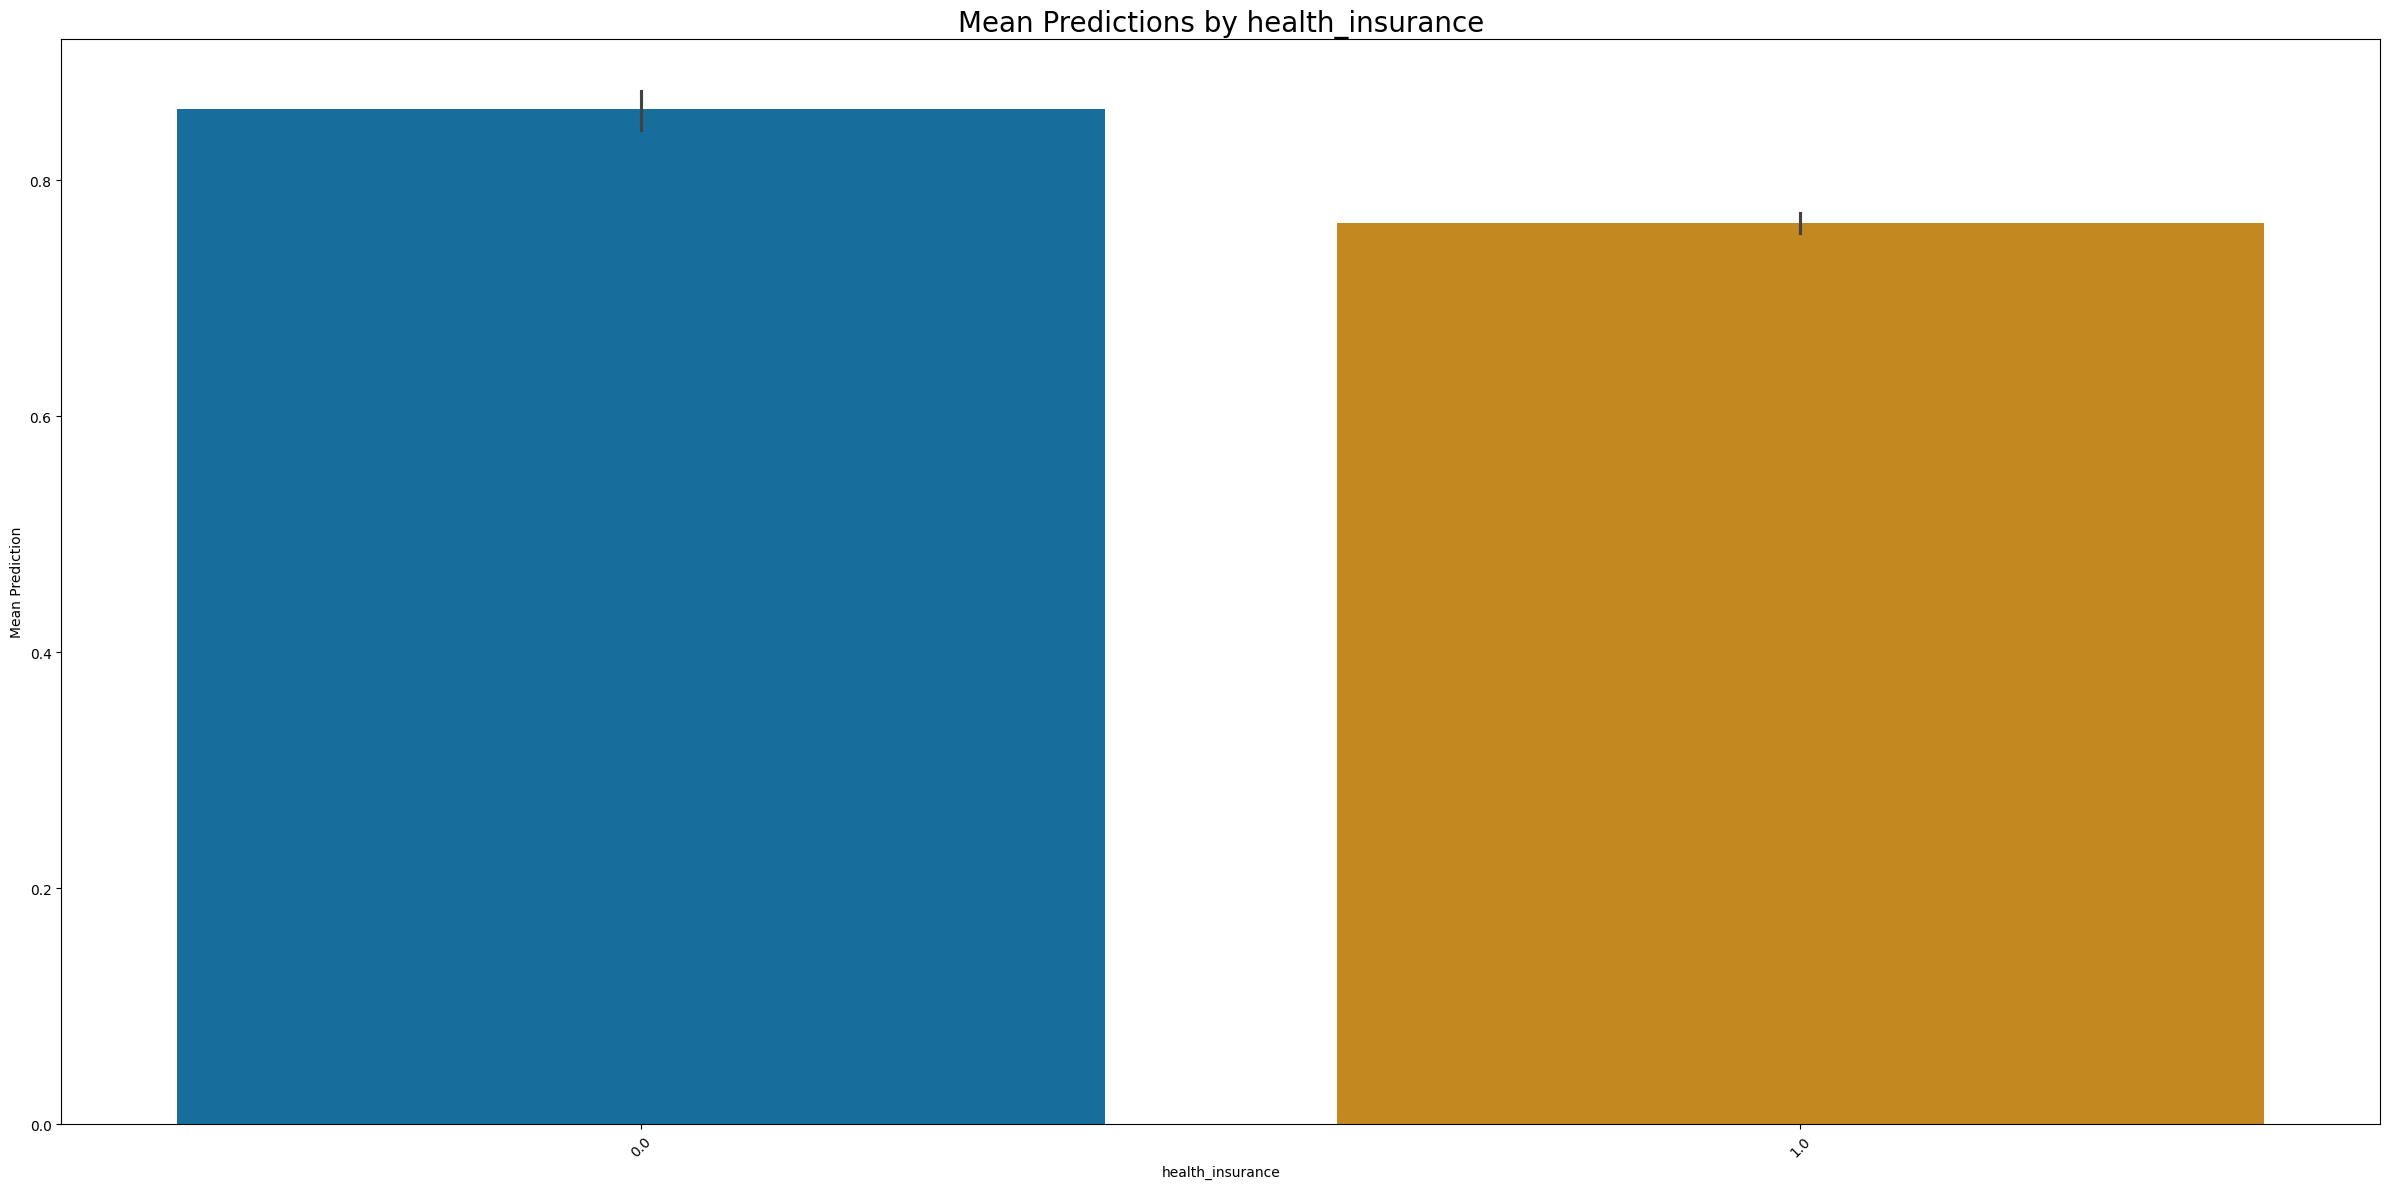

                  Mean Prediction
health_insurance                 
0.0                      0.860403
1.0                      0.763942


In [247]:
explore('health_insurance')

Exporting X_preds DataFrame to use in creating Power BI visualizations.

In [248]:
#X_preds.to_csv('h1n1vaccines.csv')